# Exploring Large Digital Libraries by Multimodal Criteria
## Version: June 2021

The original publication is available [online](https://link.springer.com/chapter/10.1007%2F978-3-319-43997-6_24).


## Why to Read this Tutorial?
* In this tutorial, you will learn to read metadata from an OAI-PMH data provider and how to convert the retrieved data from Dublin Core to a pandas data frame.
* Furthermore, you will carry out some basic data analysis on your data in order to find out if the data is corrupt or unclean. Based on an example, you will clean some aspects of your data.
* Finally, you will analyse and visualize the data with the help of a network graph.

![title](img/architecture.png)

### Preparations
The following code snippet initializes your Python run-time enviroment in order to run all of the subsequent actions.

If you have installed everything correctly with the help of [Anaconda](https://www.continuum.io/downloads) as explained in [dst4l0.ipynb](https://github.com/elektrobohemian/dst4l-copenhagen/blob/master/dst4l0.ipynb), the following packages should be installed correctly and be importable without problems.

#### Additional Configuration of This Notebook

In [1]:
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'allowDownloads' to True, all images will be downloaded and processed again
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowDownloads=True # should be True if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Download directory used for images etc.
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
downloadDir="./tmp/"

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Keep original downloaded TIFF images? Otherwise, they will be deleted and only JPEG thumbnails remain after download.
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

keepTIFFs=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'demoClustering' to False, the clustering steps will take about 2 hours
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
demoClustering=False # should be False if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set 'allowComputationallyExpensiveCalculations' to True, various time consuming tasks (some of them running 
# several hours) will be carried out and not only loaded from pre-computed data files
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowComputationallyExpensiveCalculations=False # should be True if you run this for the first time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# Enabling this action activates exact string matching againt name lists
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
allowExactStringMatching=True

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set to True, some plots will be saved as PDF documents in ./figures/
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
saveFiguresAsPDF=True

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If you set to True, Google Map API will be used to resolve location names, if False OpenStreetMap will be used
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *i
useGoogleMapsAPI=False
privateGoogleKey='ENTER YOUR KEY HERE' #if you want to use Google, you need a personal key

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, OpenStreetMap API will be used to fetch spatial names and alternative localized names, should be True at first run
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
getSpatialNamesFromOSM=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, details per PPN will be saved as separate JSON files in "jsonWebDir"
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
serializePPNLookup2JSON=False
jsonWebDir="./web/data/ppn/"

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, the raw features created by the Java application will be read from disk and converted for further usage, must be True at first run
#
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
reinterpretVisualWordRawFeatures=False

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
#
# If set to True, a HTTP webserver will be started after all cells have been processed to show the results
# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
launchHTTPServer=False

In [2]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import json
import networkx as nx # network analysis
from networkx.readwrite import json_graph
import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import subprocess as subp
import gzip
import math
import codecs

from jellyfish import jaro_distance, jaro_winkler, hamming_distance, levenshtein_distance
import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from skimage import io, exposure
from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

# OAI
from sickle import Sickle

# image handling
from PIL import Image

# geo stuff
import googlemaps
from geopy.distance import geodesic
import geojson as gj

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

if not os.path.exists(downloadDir):
        os.makedirs(downloadDir)
if not os.path.exists("./picklez/"):
        os.makedirs("./picklez/")
if not os.path.exists("./figures/"):
        os.makedirs("./figures/")
if not os.path.exists("./graphs/"):
        os.makedirs("./graphs/")
if not os.path.exists("./graphs/generics/"):
        os.makedirs("./graphs/generics/")        
if not os.path.exists("./html/"):
        os.makedirs("./html/")
if not os.path.exists("./web/"):
        os.makedirs("./web/")
if not os.path.exists("./web/qa/"):
        os.makedirs("./web/qa/")
if not os.path.exists("./web/data/"):
        os.makedirs("./web/data/")
if not os.path.exists("./web/data/ppn/"):
        os.makedirs("./web/data/ppn/")
if not os.path.exists("./web/data/layers/"):
        os.makedirs("./web/data/layers/")

## Retrieving Data
### Connecting to the OAI-conform Repository and Downloading Metadata Records

The next cell connects to the Berlin State Library OAI-PMH server to download metadata records in the [Dublin Core format](http://dublincore.org/).
The records are then saved locally to work with them later. For the sake of simplicity, the saving relies on the pickling mechanism of Python - its built-in object serialization method. In a productive use case, you might reach the limits of the pickle package because of the resulting file size. A viable alternative is [HDF5](https://www.h5py.org/).

In [4]:
savedRecords=[]
if allowDownloads:
    # connect to a metadata repository
    sickle = Sickle('http://digital.staatsbibliothek-berlin.de/oai')

    # for debugging purposes you might want to uncomment the following commands
    # get the sets from the data provider connected to
    #sets = sickle.ListSets()
    # print the returned sets including their identifiers
    #print("Sets provided by data provider\n* * * * * * * * * * * * * * * * * * * * * ") # \n creates a new line
    #for s in sets:
    #    print("'"+s.setName+"' accessible via: '"+s.setSpec+"'")

    # get the records from this repository's specific document set 'DC_krieg.1914.1918' (documents related to World War I) 
    # using Dublin Core format 
    records = sickle.ListRecords(metadataPrefix='oai_dc', set='all')

    printLog("Starting OAI-PMH record download...")
    # initialize some variables for counting and saving the metadata records
    savedDocs=0
    # 2:15 h for 100k
    maxDocs=120000 
    # 100 is just for testing, for more interesting results increase this value to 1000. ATTENTION! this will also take more time for reading data.
    #maxDocs=100
    
    # save the records locally as we don't want to have to rely on a connection to the OAI-PMH server all the time
    # iterate over all records until maxDocs is reached
    # ATTENTION! if you re-run this cell, the contents of the savedRecords array will be altered!
    for record in records:
        # get the PPN of the digitized work as the DC identifier will reference different (analog) manifestations
        tokens=record.header.identifier.split(":")
        tokens
        for t in tokens:
            if t.startswith("PPN"):
                # the array building simply fixes the issue that all DC field come as arrays
                record.metadata['PPN']=[t]
        
        # check if we reach the maximum document value
        if savedDocs<maxDocs:
            savedDocs=savedDocs+1
            # save the current record to the "savedRecords" array
            savedRecords.append(record.metadata)
            if savedDocs%1000==0:
                printLog("Downloaded %d of %d records."%(savedDocs,maxDocs))
        # if so, end the processing of the for-loop
        else:
            break # break ends the processing of the loop

    printLog("Finished OAI-PMH download of "+str(len(savedRecords))+" records.")
    pickle.dump( savedRecords, open( "save_120k_dc_all.pickle", "wb" ) )
else:
    printLog("Loading OAI-PMH records from disk...")
    savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )
    printLog("Done.")

[2021-06-12 20:56:39.590787]	Loading OAI-PMH records from disk...
[2021-06-12 20:56:41.149116]	Done.


In [ ]:
# uncomment this cell if you want to split the image download to two different computers
# in this case, one computer will use "even_dc_all.pickle" while the other will use "odd_dc_all.pickle" in the next cell

#availableKeys=dict()
#evenRecords=[]
#oddRecords=[]

#for i,r in enumerate(savedRecords):
#    for k in r.keys():
#        if not k in availableKeys:
#            availableKeys[k]=1
#        else:
#            availableKeys[k]=availableKeys[k]+1
#    if i%2==0:
#        evenRecords.append(r)
#    else:
#        oddRecords.append(r)

#pickle.dump( evenRecords, open( "even_dc_all.pickle", "wb" ) )
#pickle.dump( oddRecords, open( "odd_dc_all.pickle", "wb" ) )

In the next step, all images are downloaded, downscaled and converted to the JPEG format.

In [27]:
# uncomment this line if you are continuing the execution of this notebook at a later point in time
#savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )

tiffDownloadPath="https://content.staatsbibliothek-berlin.de/dms/%PPN%/800/0/00000001.tif?original=true"
    
countSavedRecords=len(savedRecords)
printLog("Started image download and processing. This will take a while...")
#logFile = open("/Volumes/2TB_WD/sbb_images/downloadIssues.txt", "w")
logFile = open(downloadDir+"/downloadIssues.txt", "w")

# surpress PIL's DecompressionBombErrors and Warnings
Image.MAX_IMAGE_PIXELS = None

for i,record in enumerate(savedRecords):
    if i%1000==0:
        if allowDownloads:
            printLog("Downloaded %d of %d images."%(i,countSavedRecords))
    
    ppn=""
    for r in record["identifier"]:
        if r.startswith("PPN"):
            ppn=r
            break
    #if len(record["identifier"])>1:
    #    ppn=str(record["identifier"][1])
    #else:
    #    ppn=str(record["identifier"][0])
    ppnTIFF=ppn+".tif"
    ppnJPEGPAth=downloadDir+ppn+".jpg"
    #if "object" in record.keys() and allowDownloads:
    if allowDownloads:
        httpCode=200
        # prevent downloading of already present files
        if not os.path.isfile(ppnJPEGPAth) :
            tryDownload=True
            # check for the HTTP error code, maybe the file does not exist
            try:
                response=urllib.request.urlopen(tiffDownloadPath.replace("%PPN%",ppn))
            except urllib.error.HTTPError as ex:
                #print("Error with %s"%tiffDownloadPath.replace("%PPN%",ppn))
                httpCode=ex.code
                tryDownload=False
            if tryDownload:
                #if allowDownloads:
                urlinfo=urllib.request.urlretrieve(tiffDownloadPath.replace("%PPN%",ppn),downloadDir+ppnTIFF)
                img = Image.open(downloadDir+ppnTIFF)
                img.thumbnail((512,512))
                img.save(downloadDir+ppn+".jpg")
                if not keepTIFFs:
                    os.remove(downloadDir+ppnTIFF)
                #ret=subp.call(["mogrify", "-resize","512x512","-format", "jpg",downloadDir+ppnTIFF])
                #if ret!=0:
                #    print("Problem with mogrifying "+ppnTIFF)
                #    logFile.write("[MOGRIFY]: %s \n%s\n\n" % (str("Problem with mogrifying "+ppnTIFF),str("Downloaded from: "+record["object"][0])))
                #ret=subp.call(["rm",downloadDir+ppnTIFF])
                #if ret!=0:
                #    print("Problem with removing "+ppnTIFF)
                #    logFile.write("[REMOVAL]: %s\n\n" % "Problem with removing "+ppnTIFF)
            else:
                print("Problem with accessing "+ppnTIFF+ " @ "+tiffDownloadPath.replace("%PPN%",ppn)+" due to HTTP code: "+str(httpCode))
                logFile.write("[HTTP]: %s\n\n" % "Problem with accessing "+tiffDownloadPath.replace("%PPN%",ppn))
                logFile.write("\tHTTP Code: "+str(httpCode)+"\n")
                #logFile.write(str(urlinfo[1])+"\n\n")
    else:
        logFile.write("[OBJECT key missing]: %s\n\n" % str(record))
logFile.close()
print("\n")
if allowDownloads:
    printLog("Finished image download and processing.")
else:
    printLog("Skipped image download and processing.")

[2021-06-12 15:07:11.324884]	Started image download and processing. This will take a while...
[2021-06-12 15:07:11.328201]	Downloaded 0 of 120000 images.
Problem with accessing PPN667471367.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN667471367/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN794142230.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN794142230/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN733240194.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN733240194/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN655723293.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN655723293/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN776963031.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN776963031/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN776707825.tif @ https://content.sta

Problem with accessing PPN756331102.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN756331102/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN717853861.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN717853861/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN71971673X.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN71971673X/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN750308397.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN750308397/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN721925812.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN721925812/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN755407903.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN755407903/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN769808468.tif @ https://content.

Problem with accessing PPN1041105266.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN1041105266/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN630355436.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN630355436/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN1041210418.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN1041210418/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN778505057.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN778505057/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN674652967.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN674652967/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN741707969.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN741707969/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN683208500.tif @ https://cont

Problem with accessing PPN823961389.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN823961389/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN688835422.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN688835422/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN663196760.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN663196760/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN780550633.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN780550633/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN746624832.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN746624832/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN566405377.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN566405377/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN828539634.tif @ https://content.

Problem with accessing PPN766445275.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN766445275/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN826266487.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN826266487/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN770997961.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN770997961/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN729083926.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN729083926/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN630519935.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN630519935/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN3343781851.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN3343781851/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN670086932.tif @ https://conten

Problem with accessing PPN671524925.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN671524925/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN789866404.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN789866404/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN771933444.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN771933444/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN770971083.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN770971083/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN82067091X.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN82067091X/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN689285043.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN689285043/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN684443090.tif @ https://content.

Problem with accessing PPN78047659X.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN78047659X/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN84678548X.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN84678548X/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN869390880.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN869390880/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN720807700.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN720807700/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN805304916.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN805304916/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN838725708.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN838725708/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN637802268.tif @ https://content.

Problem with accessing PPN749458119.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN749458119/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN679592717.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN679592717/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN741338971.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN741338971/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN719324262.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN719324262/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN717824470.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN717824470/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN739239694.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN739239694/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN73861274X.tif @ https://content.

Problem with accessing PPN773142975.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN773142975/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN729747212.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN729747212/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN799126918.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN799126918/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN1011868164.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN1011868164/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN817358455.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN817358455/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN868585203.tif @ https://content.staatsbibliothek-berlin.de/dms/PPN868585203/800/0/00000001.tif?original=true due to HTTP code: 500
Problem with accessing PPN1043636463.tif @ https://conte

ContentTooShortError: <urlopen error retrieval incomplete: got only 1883422 out of 2351419 bytes>

Please note that images will not be downloaded for some metadata records. This is no error because periodicals or multivolume work do not come with presentation images.

### Creating a Dataframe from the Metadata Records

Creating a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) is always a good idea if you want to work with your data in a tabular way as it provides means to export, select, and analyse the data. There are many more opportunities, e.g., you can even use dataframes to pose queries on the data.

In the next cell, the downloaded data is converted to a Python dict that will then be converted to a dataframe in a, honestly speaking, very verbose way...

In [113]:
# load the records
printLog("Loading pickled records...")
# uncomment this line if you are continuing the execution of this notebook at a later point in time
savedRecords=pickle.load( open( "save_120k_dc_all.pickle", "rb" ) )
printLog("Finished loading pickled records.")

availableKeys=dict()

# check for all keys present in the previously downloaded dataset
for i,r in enumerate(savedRecords):
    for k in r.keys():
        if not k in availableKeys:
            availableKeys[k]=1
        else:
            availableKeys[k]=availableKeys[k]+1
    
print(availableKeys)

# create a dictionary for the records
values=dict()
# take the keys as they have found within the downloaded OAI records
keys=availableKeys.keys()
# for every metadata field, create an empty array as the content of the dictionary filed under the key 'k'
for k in keys:
    values[k]=[]
# in addition, store the PPN (the SBB's unique identifier for digitized content)    
#values["PPN"]=[]

# iterate over all saved records
for record in savedRecords:
    # we cannot iterate over the keys of record.metadata directly because not all records cotain the same fields,...
    for k in keys:
        # thus we check if the metadata field 'k' has been created above
        if k in values:
            # append the metadata fields to the dictionary created above
            # if the metadata field 'k' is not available input "None" instead
            #values[k].append(record.get(k,["None"])[0].encode('ISO-8859-1'))
            if k in record:
                value=record.get(k)[0]
                if value:
                    if value.isdigit():
                        value=int(value)
                    else:
                        #p27 value=value.encode('ISO-8859-1')
                            #value=value.encode('ISO-8859-1').decode("utf-8", "backslashreplace")
                        value=value
                    values[k].append(value)
                else:
                    values[k].append(np.nan)
            else:
                values[k].append(np.nan)
# create a data frame from the 
#p27 df=pd.DataFrame(pd.to_numeric(values,errors='coerce'))
df=pd.DataFrame(values)
df['date']=pd.to_numeric(df['date'],errors='ignore',downcast='integer')
#df=pd.DataFrame(values)
#df=df.convert_objects(convert_dates=False, convert_numeric=True, convert_timedeltas=False, copy=True)
df.shape

[2021-06-12 22:04:53.958177]	Loading pickled records...
[2021-06-12 22:04:56.402413]	Finished loading pickled records.
{'title': 120000, 'creator': 96090, 'subject': 119989, 'type': 120000, 'format': 120000, 'identifier': 120000, 'language': 89713, 'date': 120000, 'relation': 114947, 'coverage': 101010, 'PPN': 120000, 'publisher': 55127, 'rights': 90158}


(120000, 13)

In [114]:
# creating a PPN list in CSV format is handy if you want to use it with sbbget from StabiHacks
df.PPN.to_csv("120k_ppn_list.csv",index=False)

# in case you want to use this data frame somewhere else, here are some sample serializations
printLog("Serializing data frame...")
# Microsoft Excel
df.to_excel("120k_sbb_sample.xlsx")
# HDF5 format
df.to_hdf("120k_sbb_sample.hdf5",key="sbb")
printLog("Done.")

[2021-06-12 22:04:58.931437]	Serializing data frame...


/Users/david/src/SBBrowse2018/venv/lib/python3.8/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['title', 'creator', 'subject', 'type', 'format', 'identifier', 'language', 'date', 'relation', 'coverage', 'PPN', 'publisher', 'rights'], dtype='object')]

  pytables.to_hdf(


[2021-06-12 22:05:32.879574]	Done.


In [115]:
# if you want to continue from here, it might be a good idea to 
# df=pd.read_excel("ppn_records_146000.xlsx")
# df.shape

## Inspecting Data

In [116]:
df.head()

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights
0,Brief von Fritz von Unruh an Margarete Hauptmann,"Unruh, Fritz von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771784589,de,NaN,Nachlass Gerhart Hauptmann digital,o.O.,PPN771784589,NaN,NaN
1,Brief an Wilhelm Speyer; 05.11.1832,"Speyer, Wilhelm",Musik,manuscript,application/mets+xml,PPN796368198,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN796368198,NaN,NaN
2,Plan einer pflanzengeographischen Uebersicht v...,"Schouw, Joakim Frederik",Alexander von Humboldt,manuscript,application/mets+xml,PPN82636702X,de,NaN,Nachlass Alexander von Humboldt digital,NaN,PPN82636702X,NaN,NaN
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN
4,"Musicalischen Divertissiments, oder In das Geh...","Bodino, Sebastiano",Musiknoten,multivolume_work,application/mets+xml,PPN667471367,NaN,1726,NaN,Augspurg,PPN667471367,Leopold,NaN


As a PPN serves as a unique identifier, make sure that all records contain one.

In [117]:
df[df.PPN.isnull()].count()

title         0
creator       0
subject       0
type          0
format        0
identifier    0
language      0
date          0
relation      0
coverage      0
PPN           0
publisher     0
rights        0
dtype: int64

Usually, we know that some columns should only contain unique values, e.g., the PPN column. Hence, it is a good starting point for the analysis to validate this hypothesis with the help of the following function.

In [118]:
# checks for unique values in each column
def uniqueValues(currentDataFrame):
    colNames=currentDataFrame.columns.values.tolist()
    for colName in colNames:
        print(colName+";\t\t unique values:\t"+str(len(currentDataFrame[colName].unique()))+ "\t total count: "+str(currentDataFrame[colName].count()))

uniqueValues(df)

title;		 unique values:	85580	 total count: 119998
creator;		 unique values:	33012	 total count: 96090
subject;		 unique values:	52	 total count: 119989
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	108248	 total count: 120000
language;		 unique values:	130	 total count: 89713
date;		 unique values:	596	 total count: 71675
relation;		 unique values:	322	 total count: 114947
coverage;		 unique values:	6045	 total count: 101010
PPN;		 unique values:	108248	 total count: 120000
publisher;		 unique values:	12445	 total count: 55127
rights;		 unique values:	13	 total count: 90158


In the unfortunate case that not all entries in the PPN column are unique, we might have retrieved duplicates. In other works, some works appear more than one time in the retrieved dataset. This is an observation we should definitely take care of later.

* https://www.maxmind.com/en/free-world-cities-database
* http://www.geonames.org/export/
* http://www.opengeocode.org/download.php#cities
* https://en.wikipedia.org/wiki/Lists_of_cities_by_country

### Classification of Data with the Help of Regular Expressions

As our last observation made us sceptical about the general data quality, we should analyse the data in more detail. Regular expressions are a handy means in order to analyse columns that we expect to follow a certain internal structure or pattern.

The next cell creates various regular expression to discover positive or negative numbers, different date ranges, emails, ISBN numbers or the like.


In [119]:
# regular expressions taken from: http://stackoverflow.com/questions/1449817/what-are-some-of-the-most-useful-regular-expressions-for-programmers
# extended by David Zellhöfer

patterns=dict()
#^ beginning of string, $ end of string, \d digits +: once or more times
patterns["positiveInteger"]="^\d+$"
patterns["negativeInteger"]="^-\d+$"
patterns["generalInteger"]="^-?\d+$"
patterns["positiveFloat"]="^\d*\.\d+$"
patterns["negativeFloat"]="^-\d*\.\d+$"
patterns["generalFloat"]="^-?\d*\.\d+$"
patterns["positiveGermanFloat"]="^\d*,\d+$"
patterns["negativeGermanFloat"]="^-\d*,\d+$"
patterns["generalGermanFloat"]="^-?\d*,\d+$"
# Date (dd mm yyyy, d/m/yyyy, etc.), in range 1000-2099 without proper February handling
patterns["dateVariant"]="^([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["year"]="^(1[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["ancientYear"]="^([0-1]?[0-9][0-9][0-9]|20[0-9][0-9])$"
patterns["century"]="^(1[0-9][Xx][Xx]|20[Xx][Xx])$"
patterns["ancientCentury"]="^([0-1]?[0-9][Xx][Xx]|20[Xx][Xx])$"
patterns["decade"]="^(1[0-9][0-9][Xx]|20[0-9][Xx])$"
patterns["ancientDecade"]="^([0-1]?[0-9][0-9][Xx]|20[0-9][Xx])$"
# year range with splitter "- / :", the splitter can be surrounded by an arbitrary amount of whitespaces (\s)
patterns["rangeYear"]="^\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"
patterns["rangeCentury"]="^\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*(\-|\/|:)\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*$"
patterns["rangeAncientYear"]="^\s*([0-1]?[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"
patterns["rangeAncientCentury"]="^\s*([0-1]?[0-9][Xx][Xx]|20[Xx][Xx])\s*(\-|\/|:)\s*(1[0-9][Xx][Xx]|20[Xx][Xx])\s*$"
patterns["rangeYear2Digit"]="^\s*(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*([0-9][0-9])\s*$"
patterns["rangeDateVariant"]="^\s*([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])\s*(\-|\/|:)\s*([1-9]|0[1-9]|[12][0-9]|3[01])\D([1-9]|0[1-9]|1[012])\D(1[0-9][0-9][0-9]|20[0-9][0-9])\s*$"

patterns["email"]="^[_]*([a-z0-9]+(\.|_*)?)+@([a-z][a-z0-9-]+(\.|-*\.))+[a-z]{2,6}$"
patterns["domain"]="^([a-z][a-z0-9-]+(\.|-*\.))+[a-z]{2,6}$"
patterns["url"]="^https?\:\/\/[a-zA-Z0-9.-]+\.[a-zA-Z]{2,3}\/?$"
patterns["ipv4"]="^(?:\d{1,3}\.){3}\d{1,3}$"
patterns["rgbHex"]="^#([a-fA-F0-9]{6}|[a-fA-F0-9]{3})$"
patterns["generalHex"]="^#[a-fA-F0-9]*$"
 
patterns["isbnPrefix"]="^ISBN(-1(?:(0)|3))?:?\x20(\s)*[0-9]+[- ][0-9]+[- ][0-9]+[- ][0-9]*[- ]*[xX0-9]$"
patterns["isbn"]="^[0-9]+[- ][0-9]+[- ][0-9]+[- ][0-9]*[- ]*[xX0-9]$"
patterns["NaN"]="^[Nn][Aa][Nn]$"

Now, it is time to find out if all date columns match the patterns specified above.

In [120]:
rowCount=0
histogram=dict()
for row in df.iterrows():
    rowCount=rowCount+1
    readDate=str(row[1]["date"])
    matchedOnce=False
    for key in patterns:
        p=re.compile(patterns[key])
        m = p.search(readDate)
        if m:
            if not key in histogram:
                histogram[key]=0
            histogram[key]=histogram[key]+1
            matchedOnce=True
        else:
            pass
    if not matchedOnce:
        print("No matches at all: "+row[1]["PPN"]+"\t for: "+str(readDate))
print("Row count: "+str(rowCount))
print(histogram)   

No matches at all: PPN1030278334	 for: 1778, Christmonat
No matches at all: PPN3303600473	 for: 16XX-1867
Row count: 120000
{'NaN': 48325, 'positiveInteger': 71356, 'generalInteger': 71356, 'year': 71356, 'ancientYear': 71356, 'century': 281, 'ancientCentury': 283, 'decade': 24, 'ancientDecade': 24, 'rangeYear': 8, 'rangeAncientYear': 8, 'rangeCentury': 2, 'rangeAncientCentury': 2}


With this information, we could improve our regular expressions from above or use other methods to clean-up the data.

In [121]:
#plt.plot(*zip(*sorted(histogram.items())))

### Inspecting Spatial Locations

Because the dataset contains a lot of historical works, the _spatial_ columns deserves further attention. To get a feeling for the data, we will inspect its contents.

In [122]:
df.coverage.head(30)

0                             o.O.
1                           Cassel
2                              NaN
3               Neukirch [Breslau]
4                         Augspurg
5                              NaN
6                              NaN
7                           Berlin
8                              NaN
9                              NaN
10                          Cassel
11                          Berlin
12                       Helgoland
13               Berlin-Nikolassee
14                   Wilhelmshaven
15                  Berlin-Westend
16           Rapallo [erschlossen]
17    Le Mesnil-le-Roi [ermittelt]
18                             NaN
19                             NaN
20                             NaN
21                         [China]
22                          Werder
23                          Vienne
24                             NaN
25                            Wien
26                          Berlin
27                          Berlin
28                  

Unfortunately, the spatial column does not only contain cities.  Sometimes, more than one city or a even a country is contained. Another variant uses square brackets. Additionally, specific bibliographic terminology indicate that no place of publication ([s.l.]=sine loco=without place or o.O. as its German equivalent) could be determined.

### Combining Data Cleansing Utilities

In [123]:
class DataCleaner:
    # matches alphanumeric character and the underscore at the beginning of the string
    #Unicode flag is needed because of Asian character sets otherwise such signs would be considered as non-alphanumeric
    regEx_AlphaNum=re.compile("^\w",re.UNICODE)
    # checks for surrounding []; will match almost everything but Asian characters
    regEx_BracketText=re.compile("^\[[\w\?\.,\sßÄäÖöÜü]*\]",re.UNICODE)
    # checks for typical spellings of the "sine loco" abbreviation "s. l."
    regEx_SineLoco=re.compile("[sSoO]\s?\.\s?[lLoO]\s?\.?\s?",re.UNICODE)
    
    def __init__(self):
        pass
    
    def cleanAncientYearStrict(self,readData):
        if type(readData)==float:
            if not readData:
                return 0
            else:
                return readData
        else:
            p=re.compile(patterns["ancientYear"])
            m = p.search(str(readData))
            if m:
                firstAppearance=m.group()
                return firstAppearance
            else:
                return np.nan
            
    def cleanSpatialText(self,readData):
        returnedString=""
        # just in case we did not get a string, we use brute force and return NaN
        if type(readData)==float:
            return ""
        else:
            #readData=str(readData)
            m = self.regEx_AlphaNum.search(readData)
            # if the string does start with a bracket...
            if not m:
                #print "No matches at all: "+row[1]["PPN"]+"\t for: "+str(readData)
                m2 = self.regEx_BracketText.search(readData)
                if m2:
                    matchedGroup=m2.group()
                    #print "\tMatch: "+matchedGroup
                    m3=self.regEx_SineLoco.search(matchedGroup)
                    if m3:
                        #print "\tMatched Sine Loco: "+str(m3.group())
                        return ""
                    else:
                        matchedGroup=matchedGroup.replace("[","").replace("]","")
                        #print "\tFinal string: "+matchedGroup
                        returnedString=matchedGroup
            # otherwise, it may still be a "sine loco"
            else:
                m3=self.regEx_SineLoco.search(readData)
                if m3:
                    #print "\tMatched Sine Loco: "+str(m3.group())
                    return ""
                else:
                    # in any case, there might be brackets left
                    returnedString=readData.replace("[","").replace("]","")
        
        # remove variants of "u.a."            
        regex = re.compile("[uU]\.\s?[aA]\.\s?",re.UNICODE)
        returnedString=regex.sub("",returnedString)
        return returnedString

### Cleaning Data

In [124]:
dc=DataCleaner()

#for row in df.iterrows():
#    print dc.cleanSpatialText(str(row[1]["spatial"]))
    
df['spatialClean'] = df.coverage.apply(dc.cleanSpatialText)
df['dateClean'] = df.date.apply(dc.cleanAncientYearStrict)

gate 2

In [125]:
df.head(30)

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean
0,Brief von Fritz von Unruh an Margarete Hauptmann,"Unruh, Fritz von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771784589,de,NaN,Nachlass Gerhart Hauptmann digital,o.O.,PPN771784589,NaN,NaN,,NaN
1,Brief an Wilhelm Speyer; 05.11.1832,"Speyer, Wilhelm",Musik,manuscript,application/mets+xml,PPN796368198,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN796368198,NaN,NaN,Cassel,NaN
2,Plan einer pflanzengeographischen Uebersicht v...,"Schouw, Joakim Frederik",Alexander von Humboldt,manuscript,application/mets+xml,PPN82636702X,de,NaN,Nachlass Alexander von Humboldt digital,NaN,PPN82636702X,NaN,NaN,,NaN
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN,Neukirch Breslau,NaN
4,"Musicalischen Divertissiments, oder In das Geh...","Bodino, Sebastiano",Musiknoten,multivolume_work,application/mets+xml,PPN667471367,NaN,1726,NaN,Augspurg,PPN667471367,Leopold,NaN,Augspurg,1726
5,Die drei Pintos; WeV C.8; J Anh.I.B.5,"Weber, Carl Maria von",Musiknoten,manuscript,application/mets+xml,PPN828227306,NaN,NaN,Musikhandschriften digital,NaN,PPN828227306,NaN,NaN,,NaN
6,"Alleluia o filii et filiae; Coro, orch; G-Dur","Cherubini, Luigi",Musiknoten,manuscript,application/mets+xml,PPN834722232,NaN,NaN,Musikhandschriften digital,NaN,PPN834722232,NaN,NaN,,NaN
7,Brief von Eugen Kloepfer an Gerhart Hauptmann,"Kloepfer, Eugen",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771111754,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771111754,NaN,NaN,Berlin,NaN
8,Schriftprobe Franz Joseph Messer (1831),"Messer, Franz Joseph",Schlüsselseiten,manuscript,application/mets+xml,PPN812570006,NaN,NaN,Einzelseiten KoFIM,NaN,PPN812570006,NaN,NaN,,NaN
9,"Sonaten; fl, vl, vla da braccio, bc; F-Dur","Janitsch, Johann Gottlieb",Musiknoten,manuscript,application/mets+xml,PPN870784056,NaN,NaN,Musikhandschriften digital,NaN,PPN870784056,NaN,NaN,,NaN


In [126]:
uniqueValues(df)

title;		 unique values:	85580	 total count: 119998
creator;		 unique values:	33012	 total count: 96090
subject;		 unique values:	52	 total count: 119989
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	108248	 total count: 120000
language;		 unique values:	130	 total count: 89713
date;		 unique values:	596	 total count: 71675
relation;		 unique values:	322	 total count: 114947
coverage;		 unique values:	6045	 total count: 101010
PPN;		 unique values:	108248	 total count: 120000
publisher;		 unique values:	12445	 total count: 55127
rights;		 unique values:	13	 total count: 90158
spatialClean;		 unique values:	5507	 total count: 120000
dateClean;		 unique values:	564	 total count: 71356


## Using Clustering for Further Data Cleansing
### Example of The Things We Are Up To

First, we create our sample data and display it.

In [127]:
words = u'Berlin Balin Cölln Köln'.split()
print(words)

print("Number of words: %i" % len(words))
for i,val in enumerate(words):
    print(str(i)+":\t "+str(val.encode('utf-8')))
    

['Berlin', 'Balin', 'Cölln', 'Köln']
Number of words: 4
0:	 b'Berlin'
1:	 b'Balin'
2:	 b'C\xc3\xb6lln'
3:	 b'K\xc3\xb6ln'


Then, we are interested in finding out whether the Jaro distance is really a distance. As you might remember from your studies, a (normalized) distance yields 1.0 a dissimilar object. Hence, the distance between "Berlin" and "Berlin" should be 0.

In [128]:
jaro_distance(u'Berlin',u'Berlin')

1.0

Obviously, it is not a distance. Therefore, we have to subtract the future results of __jaro_distance()__ from 1.0 to get a real distance score.

In the next step, we create a triangle matrix with the indices from above.

In [129]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.triu_indices.html
# 2nd parameter:
# Diagonal above which to zero elements. k = 0 (the default) is the main diagonal, k < 0 is below it and k > 0 is above."""
# r= Return the indices for the upper-triangle of an (n, m) array. da m nicht angegeben ist, wird n=m angenommen
# m is not passed, hence m=n

# sagen, dass die matrix square ist!
r=np.triu_indices(n=len(words), k=1)
r

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

The resulting triangle matrix can be read by referring to the indices of our sample data.
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & a_{1,1} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & a_{2,2} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, stands for the difference between "Berlin" (index 0) and "Balin" (index 1). In other words:
$$
A=
\begin{pmatrix}
\mbox{Berlin, Berlin} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & \mbox{Balin, Balin} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & \mbox{Cölln, Cölln} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & \mbox{Köln, Köln}
\end{pmatrix}
$$

To calculate the distance between the different terms represented by the triangle matrix, we have to provide a distance function that will be applied to each term pairs.

In [130]:
def d_demo(coord):
    print(coord)
    i, j = coord
    # the distance fix we have learnt about before...
    return 1-jaro_distance(words[i], words[j])

In [131]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4)

# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d_demo, 0, r)
r2

[0 1]
[0 2]
[0 3]
[1 2]
[1 3]
[2 3]


array([0.1778, 0.4222, 0.3889, 0.4   , 0.3667, 0.2167])

The resulting array contains the values of the triangle matrix:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{0.1778} & \underline{0.4222} & \underline{0.3889} \\
\cdot & a_{1,1} & \underline{0.4} & \underline{0.3667} \\
\cdot & \cdot & a_{2,2} & \underline{0.2167} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, shows that the difference between "Berlin" and "Balin" is 0.17777778.

The elements on the diagonal are left out for good reason because we can safely assume that the difference between the same terms will be 0 using our difference function.

### Working with Real Data

Again, we have to define the distance function first and construct a triangle matrix in accordance with our real data.

In [132]:
def d(coord):
    #print(coord)
    i, j = coord
    #py27 return 1-jaro_distance(unicode(str(words[i]), 'utf-8'), unicode(str(words[j]), 'utf-8'))
    return 1-jaro_distance(words[i],words[j])

In [133]:
df3=df

uniqueSpatials=df3["spatialClean"].unique()
words=None
if demoClustering:
    words=uniqueSpatials[:100] # only consider the first 100 elements for performance reasons
else: # during normal operation, we want to consider all unique spatial names...
    words=uniqueSpatials
r=np.triu_indices(len(words), 1)

The next step will take some time, hence we have limited the number of spatial labels before in demo mode.

In [134]:
printLog("Started calculation of distance matrix for %i words..."%len(words))
# _ is the last evaluated value in an interactive shell
# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d, 0, r)
printLog("Finished calculations.")

[2021-06-12 22:06:53.238057]	Started calculation of distance matrix for 5507 words...
[2021-06-12 22:08:17.625957]	Finished calculations.


agglomeratives Clustering (hier nearest points, bottum-up) im gegensatz zu divisiven (top-down), das Beispiel hier nutzt den nearest point algorithm (Formel siehe https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html)

In [135]:
Z=scipycluster.linkage(r2)

if not demoClustering:
    pickle.dump( Z, open( "cluster_hierarchy_linkage_result_without_name_clustering.pickle", "wb" ) )

#Z
# scientific notation erklären

i müsste Zeile sein

A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

mehr infos: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/


In [136]:
#Z=pickle.load( open( "cluster_hierarchy_linkage_result.pickle", "rb" ) )
if demoClustering:
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
    )
    plt.show()


* fcluster macht aus der clusterhierarchie wiederum "flat clusters"

In [137]:
clusters=scipycluster.fcluster(Z, t=0.1,criterion="distance")
# 2. parameter ist abhängig von der clustering strategie, -> cophenetic distance
# see: http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
# An array of length n. T[i] is the flat cluster number to which original observation i belongs.


# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cophenetic.html
# https://en.wikipedia.org/wiki/Cophenetic
# wir erhalten für jedes unser elemente eine cluster ID
clusters

array([4041, 1335,  311, ..., 1462, 2851, 1241], dtype=int32)

service functions that help to establish a linkage between the cluster IDs and human readable names

In [138]:
def getWordIndex(word):
    return np.where(words==word)[0]

def getClusterID(data):
#for row in df3.iterrows():
    #data=row[1]["spatialClean"]
    #wordIndex=np.where(words==data)[0]
    #if data == u"奈良".encode('utf-8'):
    #    print "China!"
    #    wordIndex=getWordIndex(data)
    #    print wordIndex
    #    print clusters[wordIndex][0]
    wordIndex=getWordIndex(data)
    if wordIndex:
        return clusters[wordIndex][0]
    else:
        return ""

### Inspecting the Clustered Results Deeper

In [139]:
#
Z_huge=pickle.load( open( "cluster_hierarchy_linkage_result_without_name_clustering.pickle", "rb" ) )
uniqueSpatials=df3["spatialClean"].unique()
words=uniqueSpatials
len(words)

5507

In [140]:
clusters=scipycluster.fcluster(Z_huge, t=0.07,criterion="distance")
clusters

array([4480, 1455,  331, ..., 1610, 3290, 1340], dtype=int32)

gate 3

In [141]:
df3['spatialCluster'] = df3["spatialClean"].apply(getClusterID)
grp=df3.groupby("spatialCluster")
#print grp.groups.keys()
print("Number of clusters: %i" % len(grp.groups.keys()))

Number of clusters: 4492


stichproben ...

In [142]:
grp.get_group(clusters[getWordIndex("Berlin")][0])

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster
7,Brief von Eugen Kloepfer an Gerhart Hauptmann,"Kloepfer, Eugen",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771111754,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771111754,NaN,NaN,Berlin,NaN,2779
11,Brief an Jean-François Le Sueur; 17.05.1823,"Le Sueur, Jean-François",Musik,manuscript,application/mets+xml,PPN774604212,NaN,NaN,Nachlässe und Autographe digital,Berlin,PPN774604212,NaN,NaN,Berlin,NaN,2779
26,Brief von Hannes M. Avenarius an Gerhart Haupt...,"Avenarius, Hannes M.",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771151470,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771151470,NaN,NaN,Berlin,NaN,2779
27,Reisepass nach Paris,"Bourgoing, Paul Charles Amable de",Nachlässe und Autographe,manuscript,application/mets+xml,PPN769829481,fr,NaN,Nachlass Chamisso digital,Berlin,PPN769829481,NaN,NaN,Berlin,NaN,2779
36,Brief von Samuel Fischer an Margarete Hauptmann,"Fischer, Samuel",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771884974,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771884974,NaN,NaN,Berlin,NaN,2779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119979,"Fürchte dich nicht, liebes Land!; Predigt am E...","Lahusen, Friedrich",Krieg 1914-1918,monograph,application/mets+xml,PPN717311015,ger,1915,Europeana Collections 1914-1918,Berlin,PPN717311015,Warneck,Public Domain Mark 1.0,Berlin,1915,2779
119986,Kolonialpolitik; mein politisches Vermächtnis,"Solf, Wilhelm Heinrich",Krieg 1914-1918,monograph,application/mets+xml,PPN688526853,ger,1919,Europeana Collections 1914-1918,Berlin,PPN688526853,Hobbing,Public Domain Mark 1.0,Berlin,1919,2779
119988,Der Spatenkrieg; ein Ratgeber in der Garnison ...,"Fitschen, Heinrich",Krieg 1914-1918,monograph,application/mets+xml,PPN721357512,ger,1916,Europeana Collections 1914-1918,Berlin,PPN721357512,Mittler,Public Domain Mark 1.0,Berlin,1916,2779
119995,Deutsche Barbaren,"Halke, Paul",Einblattdrucke,monograph,application/mets+xml,PPN774640855,ger,1915,Europeana Collections 1914-1918,Berlin,PPN774640855,NaN,Public Domain Mark 1.0,Berlin,1915,2779


shortcut, because we are only interested in the unique names within a cluster...

In [143]:
grp.get_group(clusters[getWordIndex("Frankfurt/Oder")][0])["spatialClean"].unique()

array(['Frankfurt', 'Frankfurt am Main', 'Frankfurt a/M',
       'Frankfurt (Main)', 'Frankfurt a.M.', 'Frankfurt a/m',
       'Frankfurt a. M.', 'Frankfurt/ M.', 'Frankfurt a. d. Oder',
       'Franckfurt am Mayn', 'Frankfurt am Mayn', 'Frankfurt a. Oder',
       'Francofurti', 'Frankfurt ', 'Frankfurt a./O.', 'Frankfurt/Main',
       'Frankfurt/Oder', 'Franckfurt', 'Franckfurth', 'Frankfurt, Main',
       'Franckfort am Mayn', 'Frankfurt, Oder', 'Frankfurt a.O.',
       'Frankfurt a/O.', 'Frankfurt a. O.', 'Frankfurt, O',
       'Frankfurt a/O ', 'Francoforti', 'Franckfurt am Mäyn',
       'Francofort', 'Frankfurth', 'Franckfurt am Main', 'Frankofurti',
       'Franckfurth am Mäyn', 'Franckfurt a.O.', 'Frankfurt (Oder)',
       'Frankfurt, M.', 'Frankfurt?', 'Frankfurt a/Oder',
       'Frankfurt a/M.', 'Frankfurt/ Main', 'Frankfurt /M.',
       'Franfurt am Main', 'Frankfurt a. Main', 'Franckfurt am Meyn',
       'Franckfurt, Main', 'Frankfurt amMain', 'Franckfurth am Mayn',
       '

semantisch sind die cluster natuerlich nicht korrekt...

a good time for inspecting all of our clusters' contents

In [144]:
for key in grp.groups.keys():
    if key:
        print(key)
        print(grp.get_group(key)["spatialClean"].unique())

1
['天台山']
2
['和歌山']
3
['蜀南薛氏桐華書屋']
4
['蜀南桐華書屋']
5
['長崎']
6
['高崎']
7
['長岡']
8
['伊勢']
9
['伊勢国津']
10
['武昌']
11
['武甯']
12
['武英殿']
13
['尚義堂 重刊']
14
['輔仁堂 刊']
15
['紹義堂 藏版']
16
['義善堂 藏版']
17
['寳章堂 藏版']
18
['玉勾草堂 藏版']
19
['玉堂']
20
['三槐堂藏版']
21
['遠源堂藏版']
22
['振賢堂梓行' '振賢堂 梓行']
23
['德文堂藏板']
24
['文畬堂藏板']
25
['貴文堂 藏板']
26
['廣慶堂 藏板']
27
['太和堂 藏板']
28
['來鹿堂 藏板']
29
['振賢堂 藏板']
30
['春暉堂 藏板']
31
['墨華堂梓行']
32
['經國堂藏板']
33
['一經堂']
34
['榮華堂 存板']
35
['汲古閣 藏版']
36
['涵遠齋 梓行']
37
['敬義齋 藏板']
38
['藝蘭圃 藏板']
39
['柏林寺 存板']
40
['本衙藏板']
41
['椒華吟舫藏板']
42
['禪山']
43
['虞山']
44
['荊州']
45
['荊州 : 荊州駐防繙譯總學']
46
['金陵書局']
47
['金陵']
48
['山東']
49
['山東書局']
50
['廣東']
51
['金閶']
52
['廣州']
53
['杭州']
54
['廣雅書局 刻']
55
['??']
56
['B???']
57
['S?']
58
['京城 서울' '京城서울']
59
['京城']
60
['江寧']
61
['江寧府學衙門藏板']
62
['北京']
63
['北京観音寺胡同家經舖刊']
64
['Slg. I 大阪']
65
['S.I.']
66
['皇都 京都']
67
['京 京都']
68
['洛陽 京都']
69
['浪華 大阪']
70
['浪花大阪']
71
['京都']
72
['京都琉璃廠']
73
['名古屋, 江戸']
74
['名古屋 ; 江戸']
75
['名古屋 ; 京都']
76
['名古屋']
77
['江戸']
78
['江戸 東京']
79
['江戸 ; 大阪'

['Ulm a. Donau' 'Ulm a.Donau']
643
['Ulm a.D.' 'Ulm a. D.']
644
['Culm a. W.']
645
['Ulm (Donau)']
646
['Kilonii' 'Kiloni']
647
['Bruchsal' 'Bruchsall']
648
['Buchschlag']
649
['Bad Schwalbach']
650
['Bacharach']
651
['Bad Schandau']
652
['Calcutta' 'Calcutta ']
653
['Kalkutta']
654
['Rapallo Hotel Excelsior' 'Rapallo Hotel Exelsior']
655
['Rapallo Grand Hotel Excelsior' 'Rapallo Grand Hotel Exelsior']
656
['Rapallo Grand Hôtel Excelsior' 'Rapallo Gr. Hôtel Excelsior']
657
['Rapallo Hotel Excelsior & New Casino']
658
['Rapallo Grand Hotel Savoia']
659
['Rapallo Gr. Hotel Exelsior & New Casino']
660
['Versailles']
661
['Marseille']
662
['Ursell']
663
['Wernigerode' 'Wernigeroda' 'Wernigerodae']
664
['Wülfingerode']
665
['Cölln an der Spree' 'Kölln an der Spree' 'Cöln an der Spree']
666
['Cölln an det Spree']
667
['Sainte-Menehould Poststempel']
668
['Sainte-Menehould']
669
['Saint-Cloud']
670
['Kaiserswerth am Rhein' 'Kaiserwerth am Rhein']
671
['Kaiserswerth am Rhein Düsseldorf']
672
[

1192
['Elberfeld Wuppertal']
1193
['Bad Kreuznach']
1194
['Bad Kreutz']
1195
['Bad Nauheim']
1196
['Bad Neuenahr']
1197
['St. Margherita Villa Nido']
1198
['St. Margherita Il Nido']
1199
['St. Margarethen']
1200
['St. Margherita']
1201
['St. Margherita La Roccia']
1202
['St. Margherita Castello Paraggi']
1203
['Stolp i. Pomm.' 'Stolp i.Pom.']
1204
['Stargardt in Pommern' 'Stargard in Pommern']
1205
['Stargard i. Pomm.']
1206
['Stargard' 'Stargardt' 'Stargardiæ']
1207
['Stargardiae']
1208
['Stargardiae Pomeranorum']
1209
['Stargardt an der Ihna']
1210
['Bingen a. Rhein' 'Bingen am Rhein']
1211
['Urach']
1212
['Unterach']
1213
['Unterach/Attersee']
1214
['Utrecht']
1215
['Utrecht: Honig']
1216
['Ultrajecti']
1217
['Berlin-Karlshorst' 'Berlin - Karlshorst']
1218
['Freistadt, Schl' 'Freistadt, Schles']
1219
['Kagel erschlossen']
1220
['Hamburg erschlossen']
1221
['Berlin erschlossen']
1222
['Oslo Grand Hotel']
1223
['Alassio Grand Hotel']
1224
['Danzig Postkarte von' 'Saig Postkarte von']


['Halle (Saale)']
1788
['Halle, Saale']
1789
['Halle <Saale>']
1790
['Halle-Saale']
1791
['Halle' 'Halae' 'Hall' 'Halla' 'Hallae' 'Halle?' 'Halle ']
1792
['Hal']
1793
['Halæ']
1794
['Halle, S.']
1795
['Halle/S.']
1796
['Calbe a. d. S' 'Calbe a. d. S.']
1797
['Halle a. S.' 'Halle a.S.']
1798
['Halle a. d. S.' 'Halle a.d.S.']
1799
['Halle a / d. S.']
1800
['Halle a. d. Saale']
1801
['Hagen i. W. ' 'Hagen i. W.' 'Hagen i.W.' 'Hagen i. W']
1802
['Hagen i. Westf.']
1803
['Halle i. W.']
1804
['Halae Salicae']
1805
['Hameln']
1806
['Hagenau/Elsass']
1807
['Hammonae']
1808
['A Haguenau']
1809
['Ploen']
1810
['Ploenae']
1811
['Posen']
1812
['Essen' 'Essen ']
1813
['Assen']
1814
['Essen-Ruhr']
1815
['Oelsnitz i. V.']
1816
['Oelsnitz']
1817
['Oberplanitz i. Sa.']
1818
['Olsnae Sil.' 'Olsnae Silesior.' 'Olsnae Siles.' 'Olsnae Siles'
 'Olsnae Silesiorum']
1819
['Olsnae']
1820
['Oelße' 'Oelß']
1821
['Olß']
1822
['Olsse' 'Olssen' 'Oelsse']
1823
['Oels']
1824
['Ols']
1825
['Wels']
1826
['Neiß' 'Neiße'

['Görlitz' 'Görltiz' 'Görliz']
2342
['Merlitz']
2343
['Gori']
2344
['Haidelbergae']
2345
['Havelberg']
2346
['Freiburg/Schweiz' 'Freiburg, Schweiz']
2347
['Freybergk' 'Freyberg']
2348
['Freiburg' 'Freiburg ']
2349
['Freiberg' 'Freibergae']
2350
['Friedberg']
2351
['Freyburg']
2352
['Fribourg']
2353
['Freiburg, Br']
2354
['Freiburg i. B. ' 'Freiburg i.B.' 'Freiburg i. Br.' 'Freiburg i. B.']
2355
['Freiburg im Br.']
2356
['Freyburg im Breisgau' 'Freyburg in Breisgau' 'Freyburg im Breyßgau']
2357
['Freiburg/Breisgau' 'Freiburg, Breisgau']
2358
['Freiburg im Breisgau' 'Freiburg i. Breisgau' 'Freiburg im Breisgau ']
2359
['Freibg im Breisgau']
2360
['Feldberg']
2361
['Velberg']
2362
['Freiburg (Baden) ']
2363
['Freiberg i. Sachsen']
2364
['Engelberg']
2365
['Friburgi Brisgoiae']
2366
['Aschaffenburg' 'Aschaffenburgi']
2367
['Spremberg']
2368
['Nuremberg']
2369
['Norimbergae' 'Noribergae']
2370
['Norimbergæ']
2371
['Nürnberg' 'Nürnberg?' 'Nürnberg ?' 'Nürnberg ']
2372
['NuÌ\x88rnberg' 'Nurnb

2845
['Athen vermutlich']
2846
['Kagel vermutlich']
2847
['Galizien vermutlich']
2848
['Berlin vermutlich']
2849
['Berlin mutmaßlich']
2850
['Hiddensee vermutlich']
2851
['Berlin vermutlich Lützowstr. 61']
2852
['Baden ermittelt']
2853
['Basel ermittelt']
2854
['Breslau ermittelt']
2855
['Athen ermittelt']
2856
['Wien ermittelt']
2857
['Halle ermittelt']
2858
['Berlin ermittelt' 'Berin ermittelt']
2859
['Berlin ermittelt Adlon']
2860
['Schwerin ermittelt']
2861
['Berlin ermittelt Hotel Adlon']
2862
['Oranien ermittelt']
2863
['Berlin ermittelt Kinder-Zoo']
2864
['München ermittelt']
2865
['Rapallo ermittelt']
2866
['Berlin Hotel Adlon']
2867
['Berlin Hotel Esplanade']
2868
['Berlin ermittelt Buchenstr. 2']
2869
['Berlin ermittelt Brückenallee']
2870
['Berlin ermittelt Klopstockstr.']
2871
['Feldberg ermittelt']
2872
['Berlin Hotel Kaiserhof']
2873
['Berlin Hotel Koschel']
2874
['Berlin Hotel Bristol']
2875
['Berlin Hotel Russischer Hof']
2876
['Karlsbad Hotel Bristol']
2877
['Bad Reine

['Szczecin']
3465
['Berlin und Stralsund']
3466
['Maṣr']
3467
['Ladis']
3468
['Bordighera']
3469
['Kniebis Freudenstadt']
3470
['Rolandseck']
3471
['Plön']
3472
['Horn']
3473
['Sztalten']
3474
['Iutrebogae']
3475
['Nice']
3476
['Spanien / Frankreich']
3477
['Maastricht']
3478
['Caub']
3479
['Blocksberg']
3480
['Bâle']
3481
['Falun']
3482
['Sylt']
3483
['Aarau']
3484
['Prüm']
3485
['Sewastopol']
3486
['Ösel']
3487
['Emmishofen']
3488
['Hemme']
3489
['Schweiz i.e. Leipzig']
3490
['St. Johann']
3491
['Vichy']
3492
['Viry']
3493
['Nap.']
3494
['Saaz']
3495
['London Langham Hotel']
3496
['Arco']
3497
['Sayn']
3498
['Wüstegiersdorf']
3499
['Vallombrosa']
3500
['Leipzig Hotel Stadt Rom']
3501
['Garmisch Hotel Lindenhof']
3502
['Vinegia']
3503
['Pesaro']
3504
['Vernoux']
3505
['Mautes']
3506
['Gnadau']
3507
['Bürgel']
3508
['Auleben']
3509
['Gollub']
3510
['Plau i. Meckl.']
3511
['Meersburg am Bodensee']
3512
['Berlin Kurfürstenhotel']
3513
['Friedrichshof / Schloß']
3514
['Bordighera Villa de

['Husum']
4073
['Koljuschki']
4074
['Donauwörth']
4075
['Côtes Lorraine']
4076
['Port-Artur']
4077
['Alzey']
4078
['Ṣaʿda']
4079
['Juist']
4080
['Plock']
4081
['Noyon']
4082
['Tōkyō']
4083
['Midlothian']
4084
['Ǧidda']
4085
['Nizza']
4086
['Florenz Villa Fontanella alla Badla']
4087
['Mekka']
4088
['Feldberg Feldberghotel und Feldbergerhof']
4089
['Colle Isarco Palace-Hotel']
4090
['Holte']
4091
['Ahrenshoop']
4092
['Bodenseegebiet']
4093
['Guadeloupe']
4094
['Byzantinisches Reich']
4095
['Büderich bei Düsseldorf - Poststempel']
4096
['Rüben-Rötha i.Sa.']
4097
['Weston-super-Mare']
4098
['Tarnopol im Schützengraben']
4099
['Oberwiederstedt']
4100
['Kaltenleutgeben']
4101
['Kempen, im Großherzogthum Posen']
4102
['Dihernfurṭ']
4103
['Vaucresson']
4104
['Niederuzwil (St. Gallen)']
4105
['Diessen vor München']
4106
['Weissstein, Bez. Breslau']
4107
['Tyntesfield, Bristol']
4108
['Liberec Reichenberg']
4109
['Morcote Lugano']
4110
['U Dubrovniku']
4111
['Karalauczuie']
4112
['o.D. Via Cale

* synonym: ['Francofurti Ad Viadrum'] as a Latin translation of Frankfurt/Oder would be long to the cluster with ['Frankfurt/Main' 'Frankfurt/Oder' 'Frankfurt, Main' 'Frankfurt, O']
* however, Frankfurt/Main and Frankfurt/Oder are to differt cities
* ['Francofurti'] is in a 1-element cluster
* ['C\xc3\xb6lln an der Spree'] is a synonym for Berlin
* duplicate entries: ['Hallae Magdeburgicae  Hallae Magdeburgicae'] 1-gram und 2-gram vergleichen!
* auf Enthaltensein von Berlin prüfen
* St. Sankt Saint Bad als Präfix behandeln

In [145]:
# backup of the dataframe as we are going to remove data from the spatialClean column
pickleCompress('./picklez/df3_unclean_spatials.picklez',df3)

[2021-06-12 22:09:08.620640]	Pickling to './picklez/df3_unclean_spatials.picklez'
[2021-06-12 22:09:12.362371]	Pickling done.


### Further Cleaning

on some occasions, we have to deal with spatialClean entries that contain multiple cities

In [ ]:
# if you want to continue from here, uncomment the following line
#df3=pickleDecompress('./picklez/df3_unclean_spatials.picklez')

In [146]:
# PPN771806655 contains multiple cities (please note that this might have changed after 2021/06/12 in case the library has revised its records)
df3[df3.PPN=="PPN771806655"]

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN,Neukirch Breslau,NaN,331


handle compound city names (only today's German cities to give an example)

* to avoid superfluous comparisons we split the city names by their leading character

In [150]:
cityNameFile_DE = open('citynames.txt', 'r')
cityNGramsDE=dict()
lastLetter=""
for line in cityNameFile_DE:
    if not line.startswith("//"):
        r=line.replace("\n","").strip()
        if " " in r:
            #print r
            if not lastLetter==r[0].lower():
                lastLetter=r[0].lower()
                cityNGramsDE[lastLetter]=[]
            cityNGramsDE[lastLetter].append(r)
            #py27 cityNGramsDE[lastLetter].append(r.decode("utf-8"))

in case of multiple cities, we will only consider the first one
not perfect but some test case will illustrate the idea

In [159]:
# Various test cases of city names
test_strings=[]
test_strings.append("Frankfurt, O")
test_strings.append('Hallae Magdeburgicae  Hallae Magdeburgicae')
test_strings.append("Leipzig  Paris  Petersburg  London")
test_strings.append('Franckfurt  N\xc3\xbcrnberg  Leipzig')
test_strings.append('Frankfurt/Main') 
test_strings.append('Frankfurt, Main')
test_strings.append('Bad Nauheim')
test_strings.append('Rottach-Egern am Tegernsee')
test_strings.append('Egern a. Tegernsee')
test_strings.append("Plancy-L'Abbaye")
test_strings.append('Bad Nauheim Sankt')
test_strings.append("Saint Tropez")
test_strings.append("Sankt Augustin")
test_strings.append("Sankt-Augustin")
test_strings.append("St. Whatever")
test_strings.append("Berlin Oberschöneweide")


def pickFirstCity(testString):
# checks if the testString contains multiple cities separated by whitespaces and returns the first city respecting city name prefixes such as Saint, St. etc.
    
    # matches for whitespaces that are NOT preceded by the following signs: ", ; : \ / " denoted in the regex by (?<!...)
    regex = re.compile("(?<![,;:\\\/])\s*\s",re.UNICODE)
    regex2 = re.compile("(?<![,;:\\\/])\s*",re.UNICODE)

    # matches various city prefix such as Saint etc.
    spatialPrefixRegExes=[]
    spatialPrefixRegExes.append(re.compile("^[Bb][Aa][Dd]\s*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ss][Aa][Nn][Kk][Tt][\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ss][Aa][Ii][Nn][Tt][\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[S][t]\.[\s-]*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Dd][Ee][Nn]\s*",re.UNICODE))
    spatialPrefixRegExes.append(re.compile("^[Ne][Ee][Ww]\s*",re.UNICODE))

    #print "Tested string: >%s<" % testString
    
    if allowExactStringMatching:
        # checks whether the spatial is known to consist of more than one word
        # for the sake of efficiency we will only check for spatial names with the same leading character (see above)
        lowTestString=testString.lower()
        if len(lowTestString)>=1:
            currentLetter=lowTestString[0]
            if currentLetter in cityNGramsDE:
                for cityName in cityNGramsDE[currentLetter]:
                    foundIndex=lowTestString.find(cityName.lower())
                    #regexCity = re.compile("^\b"+cityName.lower()+"\b",re.UNICODE)
                    r=re.match("\\b"+cityName.lower()+"\\b",lowTestString)
                    #if foundIndex==0:
                    if r is not None:
                        #print "Compound city: "+cityName+" @ "+str(foundIndex)
                        return cityName
    
    # if the string is not splitable by spaces skip futher processing
    if len(testString.split(" "))<2:
        return testString
        
    # general purpose splitting
    foundSpatialPrefix=False
    for i,r in enumerate(spatialPrefixRegExes):
        m = r.search(testString)
        if m:
            #print "Prefix %i" %i
            foundSpatialPrefix=True
            #print("Spatial prefix form %i to %i"%(m.start(),m.end()))
    #print type(testString)
    
    t=regex.search(testString)
    #if t:
    #    print("\tTesting for separator: %i - %i"%(t.start(),t.end()))
    m = regex.split(testString)
    #m = regex.search(testString)
    #print(m)
    
    if foundSpatialPrefix:
        #print("spatial prefix")
        if len(m)>1:
            return m[0]+" "+m[1]
    else:
        if m:
            return m[0]
        else:
            return testString

for cities in test_strings:
    print("First pick for >%s<: %s"%(cities,pickFirstCity(cities)))   

First pick for >Frankfurt, O<: Frankfurt, O
First pick for >Hallae Magdeburgicae  Hallae Magdeburgicae<: Hallae
First pick for >Leipzig  Paris  Petersburg  London<: Leipzig
First pick for >Franckfurt  NÃ¼rnberg  Leipzig<: Franckfurt
First pick for >Frankfurt/Main<: Frankfurt/Main
First pick for >Frankfurt, Main<: Frankfurt, Main
First pick for >Bad Nauheim<: Bad Nauheim
First pick for >Rottach-Egern am Tegernsee<: Rottach-Egern am Tegernsee
First pick for >Egern a. Tegernsee<: Egern
First pick for >Plancy-L'Abbaye<: Plancy-L'Abbaye
First pick for >Bad Nauheim Sankt<: Bad Nauheim
First pick for >Saint Tropez<: Saint Tropez
First pick for >Sankt Augustin<: Sankt Augustin
First pick for >Sankt-Augustin<: Sankt-Augustin
First pick for >St. Whatever<: St. Whatever
First pick for >Berlin Oberschöneweide<: Berlin


bevor man die erste stadt auswählt muss man, sich die einträge mit mehr als einer stadt speichern.

In [160]:
counter=0
maxItems=df3.shape[0]

multipleCitiesPPN=dict()

printLog("Processing multiple spatial names entries...")
for row in df3.iterrows():
    ppn=str(row[1]["PPN"])  
    spatialC=str(row[1]["spatialClean"])
    multipleCitiesPPN[ppn]=[]
    
    counter=counter+1
    if counter%10000==0:
        printLog("\tProcessed %i items of %i"%(counter,maxItems))
                
    if spatialC:
        origSpatialClean="<"+spatialC+"> ("+ppn+")"
        f=pickFirstCity(spatialC)
        loopCount=1
        while f:
            #print f
            multipleCitiesPPN[ppn].append(f)
            #py27 spatialC=spatialC.decode("utf-8")
            spatialC=re.sub('\s+',' ',spatialC.replace(f,u"")).strip()
            #py27 spatialC=spatialC.encode("utf-8")
            if spatialC:
                #print "<"+f.encode("utf-8")+"> | <"+spatialC+">"
                #f=spatialC
                f=pickFirstCity(spatialC)
            else:
                #print origSpatialClean
                break
            loopCount=loopCount+1
            if loopCount>15:
                printLog("Max. loop count reached @ "+origSpatialClean+ " with last f of: <"+f+">")
                break
        #if f:
            #spatialC=spatialC.decode("utf-8")
            #spatialC=spatialC.replace(f,u"").strip()
            #spatialC=spatialC.encode("utf-8")
            #if spatialC:
                #print origSpatialClean
                #print "<"+f.encode("utf-8")+"> | <"+spatialC+">"
                #counter=counter+1
                #if counter==10:
                    #break
    #print ppn
    #break
printLog("Done.")
pickleCompress("./picklez/multipleSpatialNamesPerPPN.picklez",multipleCitiesPPN)

[2021-06-13 08:45:03.311126]	Processing multiple spatial names entries...
[2021-06-13 08:45:04.291691]		Processed 10000 items of 120000
[2021-06-13 08:45:05.125041]		Processed 20000 items of 120000
[2021-06-13 08:45:05.923882]		Processed 30000 items of 120000
[2021-06-13 08:45:06.780504]		Processed 40000 items of 120000
[2021-06-13 08:45:07.612954]		Processed 50000 items of 120000
[2021-06-13 08:45:08.443855]		Processed 60000 items of 120000
[2021-06-13 08:45:09.260715]		Processed 70000 items of 120000
[2021-06-13 08:45:10.151469]		Processed 80000 items of 120000
[2021-06-13 08:45:10.982424]		Processed 90000 items of 120000
[2021-06-13 08:45:11.808725]		Processed 100000 items of 120000
[2021-06-13 08:45:12.655657]		Processed 110000 items of 120000
[2021-06-13 08:45:13.515267]		Processed 120000 items of 120000
[2021-06-13 08:45:13.515891]	Done.
[2021-06-13 08:45:13.516211]	Pickling to './picklez/multipleSpatialNamesPerPPN.picklez'
[2021-06-13 08:45:13.881225]	Pickling done.


display the PPNs with multiple spatial names

In [161]:
for ppn in multipleCitiesPPN:
    array=multipleCitiesPPN[ppn]
    if len(array)>1:
        print(ppn+":\t"+"; ".join(array))

PPN771806655:	Neukirch; Breslau
PPN775039780:	Rapallo; erschlossen
PPN739752820:	Le; Mesnil-le-Roi; ermittelt
PPN771076185:	San; Remo; Pension; Aurora
PPN771889712:	Grunewald; bei; Berlin
PPN771822944:	Rheinfelden; Salinenhotel
PPN771205058:	Düsseldorf; Kaiserwerth
PPN771888481:	Grunewald; bei; Berlin
PPN739755595:	Braine; (Aisne); ermittelt
PPN77506730X:	Blankenese; bei; Hamburg
PPN771896786:	Berlin; vermutlich
PPN771198418:	Berlin; Poststempel
PPN73975503X:	Paris; Poststempel
PPN77112774X:	Berlin-Charlottenburg; Pension; Bavaria
PPN739745344:	Berlin; ermittelt
PPN77120471X:	Kaiserswerth; am; Rhein
PPN775067962:	Karlsbad; Hotel; Bristol
PPN771894457:	Rovio; Poststempel
PPN775066605:	Bad Warmbrunn; Schlesien
PPN71611691X:	Baden bei; Wien
PPN769813976:	Schöneberg; (Berlin)
PPN771147279:	Rieben; Ortsteil; der; Stadt; Beelitz
PPN771897332:	Genova; Poststempel
PPN836018915:	Aranjuez; sowie; Madrid
PPN739747460:	Plymouth; ermittelt
PPN771238320:	Charlottenburg; Berlin
PPN771788231:	Erkner; 

PPN771243022:	Berlin; vermutlich
PPN771227523:	Kaiserswerth; am; Rhein; Düsseldorf
PPN771187815:	Bad Reichenhall; Hotel; am; Predigtstuhl
PPN771888805:	Grunewald; bei; Berlin
PPN771839065:	Moosach; Poststempel
PPN771094566:	Rapallo; Hotel; Excelsior
PPN771179006:	Charlottenburg; Berlin
PPN771782683:	Wilmersdorf; Berlin
PPN775066796:	Berin; ermittelt
PPN73974884X:	Berlin; vermutlich
PPN739748505:	Berlin; vermutlich
PPN771106785:	Berlin; -; Charlottenburg; Cecilienhaus
PPN771149379:	Baden-Baden Brenners; Parkhotel; "Kurhof"
PPN73975601X:	Braine; (Aisne); Poststempel
PPN77114766X:	Frankfurt; a.; M.
PPN771076428:	Castelraimondo; vermutlich
PPN769813631:	Tegel; (Berlin)
PPN797107223:	Frankfurt; a/m
PPN688369901:	Frankfurt; a.M.
PPN771086881:	Berlin; Poststempel
PPN771156073:	Berlin; vermutlich
PPN739754912:	Paris; Poststempel
PPN739750291:	Berlin; ermittelt
PPN771107455:	Bad Kissingen; Kurhaus; Fürstenhof
PPN778827089:	La; Haye
PPN745184790:	Neuburg; a.D.
PPN771072139:	East; Grinstead; Shov

PPN1724155709:	Ohne; Ort
PPN1753962501:	Frankfurt; a.M.
PPN739748289:	Berlin; vermutlich
PPN771839979:	Mittelschreiberhau; mutmaßlich
PPN771888562:	Chantarella; St. Moritz
PPN771199910:	Berlin; Grunewald
PPN771217315:	Düsseldorf; Kaiserswerth; am; Rhein
PPN671799843:	Bonn; et; Cologne
PPN771147147:	Berlin; W.; Hotel; Bellevue
PPN771890567:	Rapallo; Villa; Carlevaro
PPN771809891:	Binz; ermittelt; Rügen
PPN771176023:	Berlin; Poststempel
PPN73974903X:	Berlin; vermutlich
PPN771126727:	Grunewald; Berlin
PPN77123676X:	Zürich; Poststempel
PPN771084013:	Zehlendorf; -; Mitte; Berlin
PPN771889372:	Rom; Hotel; de; Russie
PPN876294190:	Schloss; Itter
PPN771839502:	Dresden; erschlossen
PPN77188947X:	Agnetendorf; i.; R.
PPN771786069:	Genova; Villa; Mare
PPN875716830:	Stettin; &; Swindemünde
PPN771096402:	Dresden; -; Weißer; Hirsch
PPN775068675:	Tarnowitz; Oberschlesien; -; Schloss; Neudeck; Kreis
PPN771824084:	Berlin; vermutlich
PPN771887825:	Grunewald; bei; Berlin
PPN739752545:	Plancy-L'Abbaye; erm

PPN1665874821:	Kleefeld; bei; Hannover
PPN77704658X:	Grünberg; i.; Schl.
PPN1664893989:	Wolkersdorf; im; Weinviertel
PPN1664890645:	Wolkersdorf; im; Weinviertel
PPN1667969021:	V; Sanktpeterburgě
PPN1013844572:	Monasterii; Westphaliae
PPN1684416450:	Erscheinungsort; nicht; ermittelbar
PPN669413992:	Mühlheim; a.d.; Ruhr
PPN788078887:	Lugduni; Batavorum
PPN671797506:	Quedlinburg; und; Leipzig
PPN756016509:	Halae; Saxonum
PPN673022021:	Lissa; i.; P.
PPN718610512:	Frankfurth; a.; d.; O.
PPN1027447562:	Süddeutschland; (Ingolstadt?)
PPN1028188218:	Frankfurt; a.M.
PPN103702480X:	V; Rimě
PPN665501501:	Lissa; i.; P.
PPN1067508163:	S.; Peterburg
PPN873657225:	Frankfurt; a.M.
PPN670449857:	Köln; am; Rhein
PPN663980453:	Franckfurt; am; Mayn
PPN846650932:	Erscheinungsort; nicht; ermittelbar
PPN71500574X:	Franckfurt; am; Mayn
PPN101434591X:	Francofurti; Ad; Moenum
PPN1014345022:	Francofurti; Ad; Moenum
PPN1677721073:	4030; Paris
PPN1014346673:	Francofurti; Ad; Moenum
PPN664383750:	Franckfurt; am; May

* interessante PPN: PPN780104447; PPN771083963; PPN792355296; PPN735012342
* Umgang mit ? klären
* Einträge des Arrays übeprüfen: Propositionen (auch Mehrwerte-Komposita wie "an der"), Nicht-Ortsnamen (z.B. Poststempel)

* finally, we can extract the first cities

* next cell might take ca. 3 min. with list-based exact matching

In [162]:
printLog("Detecting and picking first cities...")
uniqueSpatials=df3["spatialClean"].unique()
beforeClusterClean=len(uniqueSpatials)
df3["spatialClean"]=df3["spatialClean"].apply(pickFirstCity)
printLog("Done.")

if allowExactStringMatching:
    pickleCompress("./picklez/df3_exactmatch_cities.picklez",df3)
else:
    df3=pickleDecompress("./picklez/df3_exactmatch_cities.picklez")
printLog("Done.")

[2021-06-13 08:47:06.886421]	Detecting and picking first cities...
[2021-06-13 08:47:10.993020]	Done.
[2021-06-13 08:47:10.994090]	Pickling to './picklez/df3_exactmatch_cities.picklez'
[2021-06-13 08:47:14.686133]	Pickling done.
[2021-06-13 08:47:14.686783]	Done.


In [163]:
df3[df3.coverage.notnull()].head(20)

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster
0,Brief von Fritz von Unruh an Margarete Hauptmann,"Unruh, Fritz von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771784589,de,NaN,Nachlass Gerhart Hauptmann digital,o.O.,PPN771784589,NaN,NaN,,NaN,
1,Brief an Wilhelm Speyer; 05.11.1832,"Speyer, Wilhelm",Musik,manuscript,application/mets+xml,PPN796368198,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN796368198,NaN,NaN,Cassel,NaN,1455
3,Brief von Erika Hamburger an Gerhart Hauptmann,"Hamburger, Erika",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771806655,de,NaN,Nachlass Gerhart Hauptmann digital,Neukirch [Breslau],PPN771806655,NaN,NaN,Neukirch,NaN,331
4,"Musicalischen Divertissiments, oder In das Geh...","Bodino, Sebastiano",Musiknoten,multivolume_work,application/mets+xml,PPN667471367,NaN,1726,NaN,Augspurg,PPN667471367,Leopold,NaN,Augspurg,1726,2125
7,Brief von Eugen Kloepfer an Gerhart Hauptmann,"Kloepfer, Eugen",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771111754,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin,PPN771111754,NaN,NaN,Berlin,NaN,2779
10,"Handschriftlicher Zettel &quot;Wache über uns,...","Spohr, Louis",Musik,manuscript,application/mets+xml,PPN856749443,NaN,NaN,Nachlässe und Autographe digital,Cassel,PPN856749443,NaN,NaN,Cassel,NaN,1455
11,Brief an Jean-François Le Sueur; 17.05.1823,"Le Sueur, Jean-François",Musik,manuscript,application/mets+xml,PPN774604212,NaN,NaN,Nachlässe und Autographe digital,Berlin,PPN774604212,NaN,NaN,Berlin,NaN,2779
12,Das Lied der Deutschen,"Hoffmann von Fallersleben, Heinrich",Nachlässe und Autographe,manuscript,application/mets+xml,PPN856912018,de,NaN,Nachlässe digital,Helgoland,PPN856912018,NaN,NaN,Helgoland,NaN,3934
13,Brief von Rolf Italiaander an Gerhart Hauptmann,"Italiaander, Rolf",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771083300,de,NaN,Nachlass Gerhart Hauptmann digital,Berlin-Nikolassee,PPN771083300,NaN,NaN,Berlin-Nikolassee,NaN,3151
14,Brief von Fritz Brehmer an Margarete Hauptmann...,"Brehmer, Fritz",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771180489,de,NaN,Nachlass Gerhart Hauptmann digital,Wilhelmshaven,PPN771180489,NaN,NaN,Wilhelmshaven,NaN,2738


gate 4

check our results

In [164]:
uniqueSpatials=df3["spatialClean"].unique()
afterClusterClean=len(uniqueSpatials)
words=uniqueSpatials
#words
print("Before cluster cleaning: %i" % beforeClusterClean)
print("After cluster cleaning: %i" % afterClusterClean)

Before cluster cleaning: 5507
After cluster cleaning: 3924


In [165]:
def d2(coord):
    #print "Altered d()"
    #print coord
    i, j = coord
    #print(str(type(words[i]))+" : "+str(type(words[j])))
    #py27 if not type(words[i])==unicode:
        #print "bumm "+ str(words[i])+" :"+str(i)
    if not words[i]:
        return 1.0
    #py27 if not type(words[j])==unicode:
        #print "bamm " + str(words[j])+" :"+str(j)
    if not words[j]:
        return 1.0
    dist=1 - jaro_distance(words[i],words[j]) # because jaro_distance is actually returning a similarity
    #print "%s vs. %s -> %f" %(words[i],words[j],dist)
    #return 1 - jaro_distance(unicode(str(words[i]), 'utf-8'), unicode(str(words[j]), 'utf-8'))
    return dist

def d3(coord):
    #print "Altered d()"
    #print coord
    i, j = coord
    #print str(type(words[i]))+" : "+str(type(words[j]))
    #py27 if not type(words[i])==unicode:
        #print "bumm "+ str(words[i])+" :"+str(i)
    if not words[i]:
        return 1.0
    #py27 if not type(words[j])==unicode:
        #print "bamm " + str(words[j])+" :"+str(j)
    if not words[j]:
        return 1.0
    dist=1 - jaro_winkler(words[i],words[j]) # because jaro_distance is actually returning a similarity
    #print "%s vs. %s -> %f" %(words[i],words[j],dist)
    return dist

vielleicht nötig, das ganze außerhalb des jupyter-notebooks auszuführen, wenn es time out probleme (siehe console) gibt

In [166]:
if not demoClustering:
    printLog("Calculating Jaro distances...")
    r=np.triu_indices(afterClusterClean, 1)
    r2=np.apply_along_axis(d2, 0, r)
    Z=scipycluster.linkage(r2)
    pickle.dump( Z, open( "cluster_hierarchy_linkage_result.pickle", "wb" ) )
    
    # Jaro-Winkler
    printLog("Calculating Jaro-Winkler distances...")
    r=np.triu_indices(afterClusterClean, 1)
    r3=np.apply_along_axis(d3, 0, r)
    Z3=scipycluster.linkage(r3)
    pickle.dump( Z3, open( "cluster_hierarchy_linkage_jw_result.pickle", "wb" ) )
    #pickle.dump( r2, open( "r2.pickle", "wb" ) )
    printLog("Distance matrices created. Done.")
    # (END_HERE_FOR_LINKAGE)

[2021-06-13 08:47:25.784078]	Calculating Jaro distances...
[2021-06-13 08:48:07.795729]	Calculating Jaro-Winkler distances...
[2021-06-13 08:48:50.112047]	Distance matrices created. Done.


### Working with the "Final" Data

In [167]:
## load stuff
printLog("Loading final data...")
# Jaro
#Z_huge=pickle.load( open( "cluster_hierarchy_linkage_result.pickle_bak", "rb" ) )
# Jaro-Winkler
Z_huge=pickle.load( open( "cluster_hierarchy_linkage_jw_result.pickle", "rb" ) )

#r2=pickle.load( open( "r2.pickle", "rb" ) )
printLog("Loading final data completed.")

[2021-06-13 08:50:00.754406]	Loading final data...
[2021-06-13 08:50:00.757390]	Loading final data completed.


group records by their cluster and display results

In [168]:
uniqueSpatials=df3["spatialClean"].unique()
words=uniqueSpatials
print(len(words))
# Jaro
#clusters=scipycluster.fcluster(Z_huge, t=0.115,criterion="distance") # je höher d, desto mehr kommt in 1 cluster
# Jaro-Winkler
clusters=scipycluster.fcluster(Z_huge, t=0.095,criterion="distance") # je höher d, desto mehr kommt in 1 cluster

print(clusters)
df3['spatialCluster'] = df3["spatialClean"].apply(getClusterID)
grp=df3.groupby("spatialCluster")

print("Number of clusters: %i" % len(grp.groups.keys()))

# save the clusters' names (for simplicity, we just take the name of the cluster's first element)
clusterNames=dict()
maxKey=-1
for key in grp.groups.keys():
    if key:
        if key>maxKey:
            maxKey=key
        if not key in clusterNames:
            clusterNames[key]=grp.get_group(key)["spatialClean"].unique()[0]
            
        print(str(key)+" <"+clusterNames[key]+"> contains:\n\t"+str(grp.get_group(key)["spatialClean"].unique()))
print("Max key value: %i"%maxKey)

3924
[2579  558 2032 ... 1430 1722  882]
Number of clusters: 2599
1 <寺町通姉小路> contains:
	['寺町通姉小路']
2 <柏林寺> contains:
	['柏林寺']
3 <天台山> contains:
	['天台山']
4 <和歌山> contains:
	['和歌山']
5 <??> contains:
	['??']
6 <B???> contains:
	['B???']
7 <Būlāq> contains:
	['Būlāq' 'Būlāg']
8 <Philadelphia> contains:
	['Philadelphia' 'Philadelphia, Pa.' 'Philadelphia, Penna.']
9 <New Philadelphia> contains:
	['New Philadelphia']
10 <Gröwohld/Trittau> contains:
	['Gröwohld/Trittau' 'Grönwohld/Trittau']
11 <Davos> contains:
	['Davos']
12 <Davidson's> contains:
	["Davidson's"]
13 <Tavoy> contains:
	['Tavoy']
14 <Ṣaʿda> contains:
	['Ṣaʿda']
15 <Ṣanʿāʾ> contains:
	['Ṣanʿāʾ']
16 <Knockaloe> contains:
	['Knockaloe' 'Knockaloe, Isle']
17 <Quasi-Welt> contains:
	['Quasi-Welt' 'quasi-Welt']
18 <Rapperswil> contains:
	['Rapperswil' 'Rapperschweyl']
19 <s'Gravenhage> contains:
	["s'Gravenhage" "s'-Gravenhage"]
20 <Upsala> contains:
	['Upsala' 'Upsaliæ']
21 <M.> contains:
	['M.']
22 <M> contains:
	['M']
23 <o.D.> con

	['Zippendorf']
582 <Zinndorf> contains:
	['Zinndorf']
583 <Lahore> contains:
	['Lahore' 'Lahr']
584 <Wittlich> contains:
	['Wittlich']
585 <Wittstock> contains:
	['Wittstock']
586 <Telkef> contains:
	['Telkef' 'Telkêf']
587 <Greifenberg> contains:
	['Greifenberg']
588 <Greifenhagen> contains:
	['Greifenhagen']
589 <Saarlouis> contains:
	['Saarlouis']
590 <Saarl.> contains:
	['Saarl.']
591 <Saarmund> contains:
	['Saarmund']
592 <Tel> contains:
	['Tel' 'Tiel']
593 <Tübingen> contains:
	['Tübingen' 'Tubingae' 'Tubingen' 'Tubingæ' 'Tubingue' 'Tvbingae']
594 <Tutzing> contains:
	['Tutzing']
595 <Diez> contains:
	['Diez' 'Die']
596 <Dessau> contains:
	['Dessau']
597 <Dessaviae> contains:
	['Dessaviae']
598 <Deßau> contains:
	['Deßau']
599 <Des> contains:
	['Des']
600 <De> contains:
	['De']
601 <Havana> contains:
	['Havana' 'Havanna' 'Habana']
602 <Hannover> contains:
	['Hannover' 'Hanoi' 'Hanover' 'Hanoviae' 'Hannover?' 'Hannoverae'
 'Hannoveræ' 'Hanoverae' 'Hannov.' 'Havniæ' 'Hanoviæ']
603

	['Steglitz-Berlin' 'Steglitz' 'Strelitz' 'Stegliz-Berlin']
1072 <Heilbronn> contains:
	['Heilbronn' 'Heylbronn' 'Heilbron']
1073 <Hallis-Saxonum> contains:
	['Hallis-Saxonum' 'Halae-Saxonum' 'Halae-Saxon.' 'Hallae-Saxonum']
1074 <Halle> contains:
	['Halle' 'Halae' 'Halæ' 'Hallae' 'Halle, Saale' 'Hall' 'Hall.' 'Halla'
 'Halle-Saale' 'Hallis' 'Halis' 'Hal' 'Halle, S.' 'Halle?' 'Hallstatt'
 'Halle/S.' 'Hal.' 'Halle, im']
1075 <Haarlem> contains:
	['Haarlem' 'Haerlem']
1076 <Haarlem-Aerdenhout> contains:
	['Haarlem-Aerdenhout']
1077 <Herat> contains:
	['Herat']
1078 <Hermanstadt> contains:
	['Hermanstadt']
1079 <Helmstadii> contains:
	['Helmstadii' 'Helmstädt' 'Helmstedt' 'Helmstadi' 'Helmestadii'
 'Helmaestadii' 'Helmstaedt' 'Helmstadt' 'Helmstad.' 'Helmestedt'
 'Helmstedt?' 'Helmtsadii' 'Helmaestadi' 'Helmstät']
1080 <Halberstadt> contains:
	['Halberstadt' 'Halberstadii' 'Halberstadi' 'Halberstad']
1081 <Hvalstad> contains:
	['Hvalstad']
1082 <Heiligenstadt> contains:
	['Heiligenstadt' 

1557 <Wien> contains:
	['Wien' 'Wienn' 'Wittenberg' 'Wittebergae' 'Wittenbergae' 'Witebergae'
 'Witten-Ruhr' 'Wien?' 'Vitembergae' 'Vittembergae' 'Witteberg'
 'Wittemberg' 'Wittenbergk' 'Wittembergk' 'Wittembergae' 'Witenbergae'
 'Vittenbergae' 'Uittembergē' 'Vitenbergae' 'Wittenb.' 'Wittebercae'
 'Witeberg' 'Vitebergae' 'Witten' 'Wittdün' 'Wittenberg?' 'Witteb.'
 'Wittenberg.' 'Wittebergiae' 'Wienne' 'Vitembergæ' 'Witttenberg'
 'Wittebrgae' 'VVitebergae' 'Wittenberge']
1558 <Mittelitalien> contains:
	['Mittelitalien']
1559 <Mittweyda> contains:
	['Mittweyda']
1560 <Vitte> contains:
	['Vitte']
1561 <Villenave> contains:
	['Villenave']
1562 <Mitteldeutschland> contains:
	['Mitteldeutschland']
1563 <Wien, Prag> contains:
	['Wien, Prag']
1564 <Wien-Grinzing> contains:
	['Wien-Grinzing']
1565 <Vinegia> contains:
	['Vinegia']
1566 <Boizenburg/Elbe> contains:
	['Boizenburg/Elbe']
1567 <Boitzenburg> contains:
	['Boitzenburg']
1568 <Bozen> contains:
	['Bozen' 'Botzen']
1569 <Bozen-Gries> conta

	['Bilbao']
2051 <Karalauczuie> contains:
	['Karalauczuie']
2052 <Mansfeld> contains:
	['Mansfeld']
2053 <Glauchau> contains:
	['Glauchau']
2054 <Oslo> contains:
	['Oslo']
2055 <Voralberg> contains:
	['Voralberg']
2056 <Pforzheim> contains:
	['Pforzheim']
2057 <Melitopol> contains:
	['Melitopol']
2058 <Hietzing> contains:
	['Hietzing']
2059 <Doesborgh> contains:
	['Doesborgh']
2060 <Gumbinnen> contains:
	['Gumbinnen']
2061 <Remscheid> contains:
	['Remscheid']
2062 <Kišinev> contains:
	['Kišinev']
2063 <Sunne> contains:
	['Sunne']
2064 <Sylt> contains:
	['Sylt']
2065 <Solms> contains:
	['Solms']
2066 <Szczecin> contains:
	['Szczecin']
2067 <Aarau> contains:
	['Aarau']
2068 <Vega> contains:
	['Vega']
2069 <Nice> contains:
	['Nice']
2070 <Bâle> contains:
	['Bâle']
2071 <M.Gladbach> contains:
	['M.Gladbach']
2072 <Prüm> contains:
	['Prüm']
2073 <Hemme> contains:
	['Hemme']
2074 <Prutz> contains:
	['Prutz']
2075 <Grenzgebiet> contains:
	['Grenzgebiet']
2076 <Fürth> contains:
	['Fürth']
2077

	['太和堂']
2563 <寳章堂> contains:
	['寳章堂']
2564 <高田山専修寺> contains:
	['高田山専修寺']
2565 <古微堂> contains:
	['古微堂']
2566 <來鹿堂> contains:
	['來鹿堂']
2567 <學古堂> contains:
	['學古堂']
2568 <義善堂> contains:
	['義善堂']
2569 <輔仁堂> contains:
	['輔仁堂']
2570 <春暉堂> contains:
	['春暉堂']
2571 <寧波> contains:
	['寧波']
2572 <美濃大垣> contains:
	['美濃大垣']
2573 <中西時務學堂新鐫> contains:
	['中西時務學堂新鐫']
2574 <四明鮑氏> contains:
	['四明鮑氏']
2575 <晦明軒> contains:
	['晦明軒']
2576 <覺亭梁氏鐫> contains:
	['覺亭梁氏鐫']
2577 <合肥李氏重刊> contains:
	['合肥李氏重刊']
2578 <あいのまち通高田町> contains:
	['あいのまち通高田町']
2580 <À> contains:
	['À']
2581 <3> contains:
	['3']
2582 <常熟> contains:
	['常熟']
2583 <à> contains:
	['à']
2584 <1> contains:
	['1']
2585 <歸安> contains:
	['歸安']
2586 <星沙> contains:
	['星沙']
2587 <藝蘭圃> contains:
	['藝蘭圃']
2588 <洛陽> contains:
	['洛陽']
2589 <横浜> contains:
	['横浜']
2590 <葛塚> contains:
	['葛塚']
2591 <根来> contains:
	['根来']
2592 <香港> contains:
	['香港']
2593 <補刻本> contains:
	['補刻本']
2594 <2> contains:
	['2']
2595 <佐渡> contains:
	['佐渡']
2596 <慈溪> contains:
	['慈溪']
2

In [170]:
grp.get_group(clusters[getWordIndex("Bamberg")][0])["spatialClean"].unique()

array(['Bamberg', 'Bambergae'], dtype=object)

In [175]:
grp.get_group(clusters[getWordIndex("Berlin")][0])["spatialClean"].unique()

array(['Berlin', 'Bergamo', 'Berlin-Dahlem', 'Berge', 'Berg',
       'Berlin-Pankow', 'Bern', 'Berlin-', 'Bernsheim', 'Berolini',
       'Bregenz', 'Bremen', 'Berlino', 'Berin', 'Gandersheim', 'Berln',
       'Bremae', 'Brieg', 'Berlin?', 'Beroloni', 'Briege', 'Berolinae',
       'Bregae', 'Berlini', 'Brigae', 'Briegk', 'Berna', 'Bernae',
       'Berne', 'Berolino', 'Bensheim', 'Berlin, Et', 'Berlin, W.',
       'Bergün', 'Berlin-Lankwitz', 'Berljné', 'Benares', 'Bentheim',
       'Brixlegg', 'Gernsheim', 'Bergen', 'Bernau', 'Berlin-Britz',
       'Berol.', 'Bremen?', 'Berlin-Tegel', 'Berolin.', 'Bremem'],
      dtype=object)

In [176]:
grp.get_group(clusters[getWordIndex("Frankfurt")][0])["spatialClean"].unique()

array(['Frankfurt', 'Frankfurt am Main', 'Frankfurt/ M.', 'Franckfurt',
       'Francofurti', 'Frankfurt/Main', 'Frankfurt/Oder', 'Franckfurth',
       'Francfort', 'Frankfurt, Main', 'Franckfort', 'Frankfurt, Oder',
       'Frankfurt, O', 'Francof.', 'Franckf.', 'Francfurti', 'Franḳfurṭ',
       'Francoforti', 'Francofurtana', 'Francofort', 'Francourti',
       'Frankofurti', 'Frankfurth', 'Frankfurt-Rödelheim', 'Francofurt.',
       'Franḳfurt', 'Franckfurt, Leipzig', 'Francofvrti', 'Frankfurt, M.',
       'Frankfurt?', 'F"ranqfurṭ', 'Frankfurt/ Main', 'Franfurt',
       'Franckfurdt', 'Francofordiae', 'Francofurticis',
       'Franckfurt, Main', 'Frankfort', 'Frankfurt, Oder?', 'Franckufurt',
       'Francofurdiae', 'Frankfurt/Main, 1562', 'Frankfurt, M',
       'Frankforth', 'Frankfurt-O.'], dtype=object)

In [177]:
grp.get_group(clusters[getWordIndex("Hamburg")][0])["spatialClean"].unique()

array(['Hamburg', 'Hambourg', 'Homburg', 'Hamburgi', 'Hamburg?',
       'Hamburgii', 'Hamburgo', 'Homberg, bei', 'Homberg',
       'Hamburg: Herold', 'Harburg', 'Hamburgk', 'Hambvrgi'], dtype=object)

writing out the spatial cluster names...

In [178]:
def getClusterName(clusterID):
    if clusterID:
        if clusterID in clusterNames:
            r=clusterNames[clusterID]
            if r:
                return r.title()
        else:
            return np.nan
    else:
        return np.nan

df3['spatialClusterName'] = df3["spatialCluster"].apply(getClusterName)

manual corrections of the spatial cluster names (über Karte gesehen)
* Carlsruhe
* Crefeld
* Weymar
* Kjøbenhavn
* Leipzig, Dresden
* St. Peterburg
* Coblentz
* Halæ

wäre besser, das vor dem Clustern zu tun

it would be cumbersome to correct everything manually without further assistance as shown below

gate 5

In [180]:
# if there was no cluster name, just take the cleaned spatial name
df3.spatialClusterName.fillna(df3.spatialClean, inplace=True)
uniqueValues(df3)

title;		 unique values:	85580	 total count: 119998
creator;		 unique values:	33012	 total count: 96090
subject;		 unique values:	52	 total count: 119989
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	108248	 total count: 120000
language;		 unique values:	130	 total count: 89713
date;		 unique values:	596	 total count: 71675
relation;		 unique values:	322	 total count: 114947
coverage;		 unique values:	6045	 total count: 101010
PPN;		 unique values:	108248	 total count: 120000
publisher;		 unique values:	12445	 total count: 55127
rights;		 unique values:	13	 total count: 90158
spatialClean;		 unique values:	3924	 total count: 120000
dateClean;		 unique values:	564	 total count: 71356
spatialCluster;		 unique values:	2599	 total count: 120000
spatialClusterName;		 unique values:	2593	 total count: 120000


* in the next step, we will extract all unique spatial cluster names for manual correction
* an Excel sheet is created which also contains statistical data about the name in order to reveal outliers

In [181]:
dfValues={'SpatialClusterName':[],'Length':[],'NoOfElements':[],'Entries':[]}

sortedUniqueDF3=df3.sort_values(by="spatialClusterName")["spatialClusterName"].unique()

for uniqueName in sortedUniqueDF3:
    if uniqueName:
        length=str(len(uniqueName))
        entries=df3[df3["spatialClusterName"]==uniqueName]["spatialClean"].unique()
        noOfElements=str(len(entries))
        entriesString=",".join(entries)
        dfValues['SpatialClusterName'].append(uniqueName)
        dfValues['Length'].append(length)
        dfValues['NoOfElements'].append(noOfElements)
        dfValues['Entries'].append(entriesString)

spDF=pd.DataFrame(dfValues)
spDF = spDF[['SpatialClusterName', 'Length','NoOfElements','Entries']]
spDF['NoOfElements'] = pd.to_numeric(spDF['NoOfElements'])
spDF['Length'] = pd.to_numeric(spDF['Length'])
spDF['NewName']=""

stdLength=spDF.std()["Length"]
avgLength=spDF.mean()["Length"]
lowerLength=avgLength-stdLength
upperLength=avgLength+stdLength

stdNoOfElements=spDF.std()['NoOfElements']
avgNoOfElements=spDF.mean()['NoOfElements']
lowerNoOfElements=avgNoOfElements-stdNoOfElements
upperNoOfElements=avgNoOfElements+stdNoOfElements

def atypicalLength(x):
    if x < lowerLength or x > upperLength:
        return True
    else:
        return False

def atypicalNoOfElements(x):
    if x < lowerNoOfElements or x > upperNoOfElements:
        return True
    else:
        return False
    

spDF['AtypicalLength']=spDF['Length'].apply(atypicalLength)
spDF['AtypicalNoOfElements']=spDF['NoOfElements'].apply(atypicalNoOfElements)

spDF.to_excel("./spatialnames.xlsx",index=False)
spDF.shape

(2592, 7)

visualization of the results

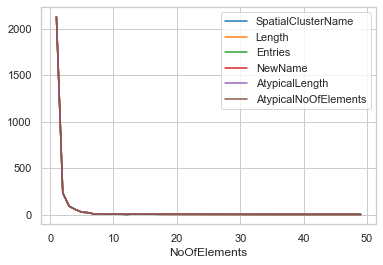

In [182]:
grpNoOfElements=spDF.groupby("NoOfElements")
grpNoOfElements.count().plot()
if saveFiguresAsPDF:
    plt.savefig('./figures/noelements_cluster.pdf')

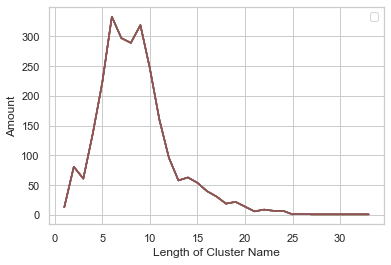

In [183]:
grpLength=spDF.groupby("Length")
grpLength.count().plot()
if saveFiguresAsPDF:
    plt.legend("")
    plt.ylabel("Amount")
    plt.xlabel("Length of Cluster Name")
    plt.savefig('./figures/length_spatialnames.pdf')

* "Poststempel", "Erscheinungsort", nicht entzifferbare Abkürzungen lassen sich so auffinden oder: St.Moritz Hotel, bzw. Kombinationen aus Verlagen und Orten; Signaturen/Referenzen: "Br117"; "VIII, 35"; (Budae,Budapest,Budapesten) wird als ein Cluster erkannt

* Excel weißt statistische Besonderheiten aus und ist alphabetisch anhand der Cluster sortiert, so kommt man in gut XX Minuten mit der Korrektur durch

* nicht alle Korrekturen sind manuell notwendig, da Ortsnamen auch Mehrsprachig in OSM oder GND(???) liegen
* Character Encoding -Probleme sind dort auch gut zu erkennen (Piešťany)

* consonant shift or sound changes

* durch die Aufbereitung in ca. 45 Minuten leistbar (inkl. Recherchen in Historischen Ortsnamen, OSM und Google)

Manual correction should be done in _spatialnamesCorrections.xlsx_. For illustration purposes, some correction have been made. Dots indicate rows for which the spatial name cluster will be removed.

In [185]:
spDF_manuallyCleaned=pd.read_excel("spatialnamesCorrections.xlsx")
spDF_manuallyCleaned.head(20)

,SpatialClusterName,Length,NoOfElements,Entries,NewName,AtypicalLength,AtypicalNoOfElements
0,1,1,1,1,.,True,False
1,2,1,1,2,.,True,False
2,2.,2,1,2.,.,True,False
3,50,2,1,50,.,True,False
4,??,2,1,??,.,True,False
5,A,1,1,A,.,True,False
6,A.,2,1,A.,.,True,False
7,Aarau,5,1,Aarau,NaN,False,False
8,Abdera,6,1,Abdera,NaN,False,False
9,Abel,4,1,Abel,NaN,False,False


In [184]:
df3[df3.spatialClusterName=="Aigen/Salzburg"].head() # returns PPN771101503 and/or PPN771101589

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster,spatialClusterName
82432,Brief von Friederike von Kap-herr an Gerhart H...,"Kap-herr, Friederike von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771101503,de,NaN,Nachlass Gerhart Hauptmann digital,Aigen/Salzburg,PPN771101503,NaN,NaN,Aigen/Salzburg,NaN,651,Aigen/Salzburg


In [186]:
df3[df3.spatialClusterName=="1"].head() # returns PPN662043146 and PPN688520944

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster,spatialClusterName
40533,Brief an Marie von Bülow; 22.06.1900,"Bülow, Marie",Musik,manuscript,application/mets+xml,PPN662043146,NaN,NaN,Nachlässe und Autographe digital,"1 Brief, 4 S.",PPN662043146,NaN,NaN,1,NaN,2584,1
77068,Postkarte an Wilhelm Engelmann; 17.12.1885,"Engelmann, Wilhelm",Musik,manuscript,application/mets+xml,PPN688520944,NaN,NaN,Nachlässe und Autographe digital,"1 Postkarte, 1 S. und Adresse",PPN688520944,NaN,NaN,1,NaN,2584,1


## korrekturen einarbeiten; sagen, welche spalten wie ausgefüllt werden müssen; vorteil excel: leute kennen das tool und können sich alles anpassen, wie sie s brauchen

In [187]:
uniqueValues(df3)

title;		 unique values:	85580	 total count: 119998
creator;		 unique values:	33012	 total count: 96090
subject;		 unique values:	52	 total count: 119989
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	108248	 total count: 120000
language;		 unique values:	130	 total count: 89713
date;		 unique values:	596	 total count: 71675
relation;		 unique values:	322	 total count: 114947
coverage;		 unique values:	6045	 total count: 101010
PPN;		 unique values:	108248	 total count: 120000
publisher;		 unique values:	12445	 total count: 55127
rights;		 unique values:	13	 total count: 90158
spatialClean;		 unique values:	3924	 total count: 120000
dateClean;		 unique values:	564	 total count: 71356
spatialCluster;		 unique values:	2599	 total count: 120000
spatialClusterName;		 unique values:	2593	 total count: 120000


### TO DO: to be fixed for current pandas version

In [188]:
# df3.ix[df3["spatialClusterName"]=="Carlsruhe", "spatialClusterName"] = "Karlsruhe"
printLog("Fixing spatial cluster names on the basis of manual corrections...")
counterRemoved=0
counterAltered=0
ignoredSpatialNamesLowerCase=[]

for row in spDF_manuallyCleaned.iterrows():
    #py27 newName=readDate=unicode(row[1]["NewName"])
    #py27 oldName=unicode(row[1]["SpatialClusterName"])
    newName=str(row[1]["NewName"])
    oldName=row[1]["SpatialClusterName"]
    
    if newName==".":
        #print("Removed: "+row[1]["SpatialClusterName"])
        df3.ix[df3["spatialClusterName"]==oldName, "spatialClusterName"] = ""
        ignoredSpatialNamesLowerCase.append(oldName.lower())
        counterRemoved=counterRemoved+1
    elif newName=="nan":
        pass
    else:
        #print("Changed: "+row[1]["SpatialClusterName"])
        df3.ix[df3["spatialClusterName"]==oldName, "spatialClusterName"] = newName
        counterAltered=counterAltered+1
        
printLog("Done.")
printLog("Removed clusters: %i"%counterRemoved)
printLog("Altered clusters: %i"%counterAltered)

[2021-06-13 09:55:49.888039]	Fixing spatial cluster names on the basis of manual corrections...


AttributeError: 'DataFrame' object has no attribute 'ix'

gate 6

In [189]:
uniqueValues(df3)

title;		 unique values:	85580	 total count: 119998
creator;		 unique values:	33012	 total count: 96090
subject;		 unique values:	52	 total count: 119989
type;		 unique values:	8	 total count: 120000
format;		 unique values:	1	 total count: 120000
identifier;		 unique values:	108248	 total count: 120000
language;		 unique values:	130	 total count: 89713
date;		 unique values:	596	 total count: 71675
relation;		 unique values:	322	 total count: 114947
coverage;		 unique values:	6045	 total count: 101010
PPN;		 unique values:	108248	 total count: 120000
publisher;		 unique values:	12445	 total count: 55127
rights;		 unique values:	13	 total count: 90158
spatialClean;		 unique values:	3924	 total count: 120000
dateClean;		 unique values:	564	 total count: 71356
spatialCluster;		 unique values:	2599	 total count: 120000
spatialClusterName;		 unique values:	2593	 total count: 120000


# spatialCluster-ID muss auch noch angepasst werden und der spatialClusterName-Anzahl entsprechen

Some debugging...

In [190]:
df3[df3.PPN=="PPN771101503"].head()

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster,spatialClusterName
82432,Brief von Friederike von Kap-herr an Gerhart H...,"Kap-herr, Friederike von",Nachlässe und Autographe,manuscript,application/mets+xml,PPN771101503,de,NaN,Nachlass Gerhart Hauptmann digital,Aigen/Salzburg,PPN771101503,NaN,NaN,Aigen/Salzburg,NaN,651,Aigen/Salzburg


In [191]:
df3[df3.PPN=="PPN662043146"].head()

,title,creator,subject,type,format,identifier,language,date,relation,coverage,PPN,publisher,rights,spatialClean,dateClean,spatialCluster,spatialClusterName
40533,Brief an Marie von Bülow; 22.06.1900,"Bülow, Marie",Musik,manuscript,application/mets+xml,PPN662043146,NaN,NaN,Nachlässe und Autographe digital,"1 Brief, 4 S.",PPN662043146,NaN,NaN,1,NaN,2584,1


In [192]:
pickleCompress('./picklez/clean_dataframe.picklez',df3)
pickleCompress('./picklez/ignoredSpatialNames.picklez',ignoredSpatialNamesLowerCase)

[2021-06-13 09:57:18.659797]	Pickling to './picklez/clean_dataframe.picklez'
[2021-06-13 09:57:22.299080]	Pickling done.
[2021-06-13 09:57:22.299690]	Pickling to './picklez/ignoredSpatialNames.picklez'
[2021-06-13 09:57:22.300296]	Pickling done.


# Geodaten erzeugen

In [221]:
# uncomment only needed if you resume the notebook
df4=pickleDecompress('./picklez/clean_dataframe.picklez')
#ignoredSpatialNamesLowerCase=pickleDecompress('./picklez/ignoredSpatialNames.picklez')

# otherwise just run this line:
#df4=df3

[2021-06-13 13:28:24.711624]	Depickling from './picklez/clean_dataframe.picklez'
[2021-06-13 13:28:25.245252]	Depickling done.


In [222]:
# not tested with Python 3
if useGoogleMapsAPI:
    # idee ist, die Algorithmen von Google zu nutzen, um mit mitunter fehlerhaften, mehrsprachigen Ortsbezeichner umzugehen
    gmaps = googlemaps.Client(key=privateGoogleKey)
    # if you re-run this cell you might want to uncomment the following line
    latLng=dict()
    printLog("Fetching geolocations from Google Maps...")
    for row in df4.iterrows():
        if not row[1]["spatialClusterName"]:
            # in some cases, i.e., when the cluster was corrected manually above, 
            # we will ignore the spatialClean replacement
            loc=row[1]["spatialClean"]
            if loc:
                if not loc.lower() in ignoredSpatialNamesLowerCase:
                    printLog("Taking %s instead."%loc)
                else:
                    loc=None
        else:
            loc=row[1]["spatialClusterName"]
        if loc:
            if loc not in latLng:
                #printLog(loc)
                try:
                    retLL=gmaps.geocode(loc)
                    if len(retLL)>0:
                        latLng[loc]=retLL[0][u'geometry'][u'location']
                    else:
                        latLng[loc]=None
                except googlemaps.exceptions.ApiError:
                    printLog("Problem fetching: "+loc)
                    latLng[loc]=None
    printLog("Done.")

    triedAgain=[]
    printLog("Fetching geolocations from Google Maps a second time (aka the brute force failover solution)...")
    for row in df4.iterrows():
        if not row[1]["spatialClusterName"]:
            loc=row[1]["spatialClean"]
        else:
            loc=row[1]["spatialClusterName"]
        if loc:
            if latLng[loc]==None:
                if loc not in triedAgain:
                    #printLog(loc)
                    triedAgain.append(loc)
                    try:
                        retLL=gmaps.geocode(loc)
                        if len(retLL)>0:
                            latLng[loc]=retLL[0][u'geometry'][u'location']
                        else:
                            latLng[loc]=None
                    except googlemaps.exceptions.ApiError:
                        printLog("Problem fetching: "+loc)
                        latLng[loc]=None
    printLog("Done.")
    pickleCompress('./picklez/geo_coordinates.picklez',latLng)
else:
    printLog("Skipping Google Map API calls.")

[2021-06-13 13:28:29.140781]	Skipping Google Map API calls.


alternative with OpenStreetMap http://wiki.openstreetmap.org/wiki/Nominatim#Reverse_Geocoding

In [ ]:
if not useGoogleMapsAPI:
    if getSpatialNamesFromOSM:
        osmNominatimURL="https://nominatim.openstreetmap.org/search?format=json&namedetails=1&q="
        # if you re-run this cell you might want to uncomment the following line
        latLng=dict()
        names=dict()
    
        maxItems=df4.shape[0]
        counter=0
    
        printLog("Fetching geolocations from OpenStreetMaps...")
        for row in df4.iterrows():
            counter=counter+1
            if counter%5000==0:
                printLog("\tProcessed %i items of %i"%(counter,maxItems))
            if not row[1]["spatialClusterName"]:
                # in some cases, i.e., when the cluster was corrected manually above, 
                # we will ignore the spatialClean replacement
                loc=str(row[1]["spatialClean"])
                if loc:
                    if not loc.lower() in ignoredSpatialNamesLowerCase:
                        printLog("No spatial cluster name for %s. Taking %s instead."%(row[1]["PPN"],loc))
                    else:
                        loc=None
            else:
                loc=str(row[1]["spatialClusterName"])
            if loc:
                if loc not in latLng:
                #printLog(loc)
                    locURL=osmNominatimURL+urllib.parse.quote(loc).replace(" ","+")
                    try:
                        data = json.load(urllib.request.urlopen(locURL))
                        latLng[loc]=dict()
                        if len(data)>0:
                            #print data[0]
                            latLng[loc][u'lat']=data[0]["lat"]
                            latLng[loc][u'lng']=data[0]["lon"]
                            #print loc
                            names[loc]=dict()
                            if len(data[0]['namedetails'])>0:
                                for k,v in data[0]['namedetails'].items():
                                    names[loc][k]=v
                            else:
                                names[loc][u'name']=loc
                                #print "No namedetails for "+loc
                            #print names[loc]
                        else:
                            latLng[loc]=None
                    except IOError:
                        printLog("\tCould not open: "+locURL)
                        pickleCompress('./picklez/save_names.picklez',names)
                        pickleCompress('./picklez/save_latLng.picklez',latLng)
                    time.sleep(1) # see http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
        printLog("Number of coordinates: %i"%len(latLng))
        printLog("Done.")
    else:
        printLog("Skipping OpenStreetMap API calls.")
else:
    printLog("Skipping OpenStreetMap API calls.")

[2021-06-13 13:41:08.464703]	Fetching geolocations from OpenStreetMaps...


In [ ]:
# for manual additions, you can directly pass an URL as the example below shows
#manualLocation="Kehl"
#data = json.load(urllib.urlopen("https://nominatim.openstreetmap.org/search?format=json&namedetails=1&q="+manualLocation))
#loc=manualLocation
#if len(data)>0:
#    latLng[loc][u'lat']=data[0]["lat"]
#    latLng[loc][u'lng']=data[0]["lon"]
#    names[loc]=dict()
#    if len(data[0]['namedetails'])>0:
#        for k,v in data[0]['namedetails'].items():
#            names[loc][k]=v
#    else:
#        names[loc][u'name']=loc
#else:
#    latLng[loc]=None

In [ ]:
# save everything
if not useGoogleMapsAPI:
    if getSpatialNamesFromOSM:
        pickleCompress('./picklez/osm_names.picklez',names)
        pickleCompress('./picklez/osm_latLng.picklez',latLng)

In [ ]:
if useGoogleMapsAPI:
    latLng=pickleDecompress('./picklez/geo_coordinates.picklez')
else:
    latLng=pickleDecompress('./picklez/osm_latLng.picklez')
    osmNames=pickleDecompress('./picklez/osm_names.picklez')

latitude und longitude aus den spatial names generieren

In [ ]:
def getLat(spatialName):
    if spatialName:
        if spatialName in latLng:
            if latLng[spatialName]:
                return latLng[spatialName][u'lat']
            else:
                return np.nan
    else:
        return np.nan

def getLng(spatialName):
    if spatialName:
        if spatialName in latLng:
            if latLng[spatialName]:
                return latLng[spatialName][u'lng']
            else:
                return np.nan
    else:
        return np.nan

df4['latitude']=df4['spatialClusterName'].apply(getLat)
df4['longitude']=df4['spatialClusterName'].apply(getLng)

### lambda-Ausdruck ansprechen (Church aus theoretischer Informatik...)

In [ ]:
# overwrite every "nulled" column (i.e. NULL or NaN) with -1
df4.ix[df4["dateClean"].isnull(), "dateClean"] = -1
df4.ix[df4["dateClean"]=='nan', "dateClean"] = -1

df4["century"]=df4["dateClean"].apply(lambda x: int(int(x)/100)) # uns interessiert nur das jahrhundert
df4.head(20)

In [ ]:
grpCentury=df4.groupby("century")
grpCentury.describe()

In [ ]:
ax=grpCentury.count().plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))

### Text-based Clustering

In [196]:
printLog("Number of unique title fields %i"%len(df4.title.unique()))

[2021-06-13 10:00:14.546923]	Number of unique title fields 85580


In [212]:
#title soll geclustert werden -> textCluster
corpus=df4.title.astype(str)
corpus

0          Brief von Fritz von Unruh an Margarete Hauptmann
1                       Brief an Wilhelm Speyer; 05.11.1832
2         Plan einer pflanzengeographischen Uebersicht v...
3            Brief von Erika Hamburger an Gerhart Hauptmann
4         Musicalischen Divertissiments, oder In das Geh...
                                ...                        
119995                                    Deutsche Barbaren
119996            Hinterm Drahtverhau; feldgraue Reimereien
119997    Gruß der Liebe aus der Heimat an die kriegsgef...
119998               Armee-Verordnungsblatt / Verlustlisten
119999    Feldmarschalleutnant Können Horak von Höhenkam...
Name: title, Length: 120000, dtype: object

The next cell will take a while to compute depending on your computer and the size of the corpus. To give an example, the following performance could be observed on a MacBook Pro (13-inch, 2018, Four Thunderbolt 3 Ports, 2,7 GHz Intel Core i7, 16 GB RAM):
```
[2019-02-25 11:08:53.568526]	Clustering text with cluster target size 5000
[2019-02-25 11:08:53.569143]		 Preparing tf*idf model
[2019-02-25 11:08:56.634801]		 Number of feature names: 125000
[2019-02-25 11:08:56.635519]		 K-Means clustering
[2019-02-25 11:17:49.427231]	Done.
```

In [214]:
# in Python 3 you cannot save files over 4 GB, hence we have to run the clustering everytime  :-/
true_k=5000

if allowComputationallyExpensiveCalculations:
    printLog("Clustering text with cluster target size %i"%true_k)
    printLog("\t Preparing tf*idf model")
    # from an analysis we know that there are 167,715 different words in the corpus
    # to speed up processing, we limit the vocabulary size to 80.000
    tfidfvectorizer = TfidfVectorizer(min_df=1,max_features=80000) #max_features is used to limit the vocabulary size 
    Xtfidf=tfidfvectorizer.fit_transform(corpus)
    featNames=tfidfvectorizer.get_feature_names()
    printLog("\t Number of feature names: %i"%len(featNames))

    printLog("\t K-Means clustering")
    km=MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=10,verbose=1)
    # fit the k-means algorithm on the data created above
    km.fit(Xtfidf)
    printLog("Pickling...")
    if sys.version_info.major<3:
        pickleCompress('./picklez/textClustersK_'+str(true_k)+'.picklez',km)
else:
    km=pickleDecompress('./picklez/textClustersK_'+str(true_k)+'.picklez')
    printLog("\t Updating Dataframe")
# add the detected clusters as a new column to the original data frame
df4['textCluster']=km.labels_
printLog("Done.")

[2021-06-13 11:14:46.134564]	Clustering text with cluster target size 5000
[2021-06-13 11:14:46.135911]		 Preparing tf*idf model
[2021-06-13 11:14:48.423597]		 Number of feature names: 80000
[2021-06-13 11:14:48.424094]		 K-Means clustering
Init 1/3 with method: k-means++
Inertia for init 1/3: 9268.935893
Init 2/3 with method: k-means++
Inertia for init 2/3: 9173.173344
Init 3/3 with method: k-means++
Inertia for init 3/3: 9188.635126
Minibatch iteration 1/12000: mean batch inertia: 0.684932, ewa inertia: 0.684932 
Minibatch iteration 2/12000: mean batch inertia: 0.669297, ewa inertia: 0.684906 
Minibatch iteration 3/12000: mean batch inertia: 0.620574, ewa inertia: 0.684799 
Minibatch iteration 4/12000: mean batch inertia: 0.654007, ewa inertia: 0.684747 
Minibatch iteration 5/12000: mean batch inertia: 0.696826, ewa inertia: 0.684767 
Minibatch iteration 6/12000: mean batch inertia: 0.695133, ewa inertia: 0.684785 
Minibatch iteration 7/12000: mean batch inertia: 0.610077, ewa inerti

In [215]:
if allowComputationallyExpensiveCalculations:
    # group the data by the cluster and describe it
    df4.groupby('textCluster').describe()

In [216]:
df4=df4.sort_values(by="textCluster")
df4[['PPN','title','textCluster']].tail()

,PPN,title,textCluster
56512,PPN685798429,Theologia D. Subtilis Scoti; In quatuor Libros...,4997
87873,PPN769032338,[Bildnis Rudolf von Valentini],4998
72370,PPN840786433,[Bildnis Rudolf Gaedechens],4998
54397,PPN768011612,"Handbuch der gerichtlichen Stempelverwaltung,;...",4999
69336,PPN768011612,"Handbuch der gerichtlichen Stempelverwaltung,;...",4999


do the same with the creator column

In [217]:
#creator soll geclustert werden -> creatorCluster
corpus=df4.creator.astype(str)
corpus

103562           Strecker, Ludwig
110727               Köhler, Pius
108774    Zerlett, Johann Baptist
28689            Strecker, Ludwig
67208            Strecker, Ludwig
                   ...           
56512               Mahler, Georg
87873               Busch, Arnold
72370                         nan
54397        Schmidt, C. O. F. G.
69336        Schmidt, C. O. F. G.
Name: creator, Length: 120000, dtype: object

In [218]:
printLog("Number of unique creator fields %i"%len(df4.creator.unique()))

[2021-06-13 11:30:36.353639]	Number of unique creator fields 33012


```
[2019-02-25 11:18:40.288281]	Clustering text with cluster target size 20000
[2019-02-25 11:18:40.289133]		 Preparing tf*idf model
[2019-02-25 11:18:40.958502]		 Number of feature names: 26575
[2019-02-25 11:18:40.959311]		 K-Means clustering
[2019-02-25 11:26:49.960392]	Done.
```

In [219]:
true_k=20000

if sys.version_info.major>=3 or allowComputationallyExpensiveCalculations:
    printLog("Clustering text with cluster target size %i"%true_k)
    printLog("\t Preparing tf*idf model")
    tfidfvectorizer = TfidfVectorizer(min_df=1) #max_features setzen?
    Xtfidf=tfidfvectorizer.fit_transform(corpus)
    featNames=tfidfvectorizer.get_feature_names()
    printLog("\t Number of feature names: %i"%len(featNames))

    printLog("\t K-Means clustering")
    km=MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=10, n_init=1)
    # fit the k-means algorithm on the data created above
    km.fit(Xtfidf)
    if sys.version_info.major<3:
        pickleCompress('./picklez/creatorClustersK_'+str(true_k)+'.picklez',km)
else:
    km=pickleDecompress('./picklez/creatorClustersK_'+str(true_k)+'.picklez')

printLog("Done.")

[2021-06-13 11:30:40.926347]	Clustering text with cluster target size 20000
[2021-06-13 11:30:40.927625]		 Preparing tf*idf model
[2021-06-13 11:30:41.438456]		 Number of feature names: 24685
[2021-06-13 11:30:41.439014]		 K-Means clustering
[2021-06-13 11:46:30.500098]	Done.


In [220]:
# add the detected clusters as a new column to the original data frame
printLog("\t Updating Dataframe")
df4['creatorCluster']=km.labels_

df4=df4.sort_values(by="creatorCluster")
df4[['PPN','creator','creatorCluster']].tail()

[2021-06-13 11:51:02.741583]		 Updating Dataframe


,PPN,creator,creatorCluster
17449,PPN76853660X,"Propiac, Catherine Joseph Ferdinand Girard",16689
6820,PPN76853755X,"Propiac, Catherine Joseph Ferdinand Girard",16689
58143,PPN750981156,"Savoyen-Carignan, Eugen",16690
116943,PPN864746458,Rukn-ad-Dīn al-Ḥasan Ibn-Muḥammad al-Astarābādī,16691
60501,PPN767839889,"Joh. Seb. Bach, Johann Sebastian",19999


In [ ]:
imageBasePath="/Users/david/src/__datasets/"
def getImageAvailability(ppn):
    if ppn:
        if os.path.exists(imageBasePath+"firstpages/"+ppn+".jpg"):
            return "firstpages/"+ppn+".jpg"
        else:
            if os.path.exists(imageBasePath+"titlepages/"+ppn+".jpg"):
                return "titlepages/"+ppn+".jpg"
            else:
                return None
    else:
        return None

printLog("Checking image availability...")
df4['titleImage']=df4['PPN'].apply(getImageAvailability)

recordsWithTitleImage=df4[df4.titleImage.notnull()].shape[0]
recordsWithoutTitleImage=df4[df4.titleImage.isnull()].shape[0]
printLog("Records with title image: %i\twithout title image (multi-volumes): %i"%(recordsWithTitleImage,recordsWithoutTitleImage))
printLog("Done.")

In [ ]:
pickleCompress('./picklez/clean_dataframe_with_century.picklez',df4)

In [ ]:
df4.to_csv("cleanedData.csv",sep=';',header=True, index=False, encoding='utf-8')
df4.to_excel("cleanedData.xlsx",header=True, index=False)

## The Analyses Shall Begin!
safe to continue from here if you resume the notebook...

In [ ]:
# if you have run this notebook from top to bottom, you don't have to reload the data
df4=pickleDecompress('./picklez/clean_dataframe_with_century.picklez')
grpCentury=df4.groupby("century")
#df4.shape

In [ ]:
uniqueValues(df4)

### Speeding things up

dauert ca.40 min mit Zugriff innerhalb der Schleife mittels df4[df4.PPN==ppn].iloc[-1]['title'], deshalb look-up, so dauert alles komplett ca. 40 Sekunden.

In [ ]:
printLog("Creating PPN look-up table of %i unique PPNs."%len(df4.PPN.unique()))
ppnLookup=dict()
for row in df4.iterrows():
    ppn=readDate=str(row[1]["PPN"])
    if ppn not in ppnLookup:
        ppnLookup[ppn]=dict()
    # it is redundant but handy for later JSON exports to save the PPN as a value as well
    ppnLookup[ppn]["ppn"]=ppn
    ppnLookup[ppn]["dateClean"]=str(row[1]["dateClean"])
    ppnLookup[ppn]["title"]=str(row[1]["title"])
    ppnLookup[ppn]["creator"]=str(row[1]["creator"])
    
    if not row[1]["spatialClusterName"]:
        if row[1]["spatialClean"]:
            ppnLookup[ppn]["spatialClusterName"]=row[1]["spatialClean"]
        else:
            ppnLookup[ppn]["spatialClusterName"]="None"
    else:
        ppnLookup[ppn]["spatialClusterName"]=row[1]["spatialClusterName"] 
    ppnLookup[ppn]['spatialClean']=row[1]["spatialClean"]
    ppnLookup[ppn]['spatialRaw']=str(row[1]["coverage"])
    ppnLookup[ppn]['mediatype']=str(row[1]["type"])
    ppnLookup[ppn]['subject']=str(row[1]["subject"])
    # daz
    #ppnLookup[ppn]['source']=str(row[1]["source"])
    ppnLookup[ppn]['publisher']=str(row[1]["publisher"])
    #ppnLookup[ppn]['alternative']=str(row[1]["alternative"])
    ppnLookup[ppn]['lat']=str(row[1]["latitude"])
    ppnLookup[ppn]['lng']=str(row[1]["longitude"])
    ppnLookup[ppn]['textCluster']=str(row[1]["textCluster"])
    ppnLookup[ppn]['creatorCluster']=str(row[1]["creatorCluster"])
    ppnLookup[ppn]['titleImage']=str(row[1]["titleImage"])
    
pickleCompress("./picklez/ppnLookup.picklez",ppnLookup)
printLog("Done.")

In [ ]:
#serialize data per PPN; one large file would be more than 80 MB and thus too much for a transmission to a browser
if serializePPNLookup2JSON:
    printLog("Serializing PPN lookup table to JSON in directory:\n\t"+jsonWebDir)
    for k in ppnLookup:
        dump=json.dumps(ppnLookup[k])

        jsonFile = open(jsonWebDir+k+".json", "w")
        jsonFile.write(dump)
        jsonFile.close()
    printLog("Done.")

### A Creation and Its Place of Origin - Graphing the Library World
build a network graph: do publishers and their publication locations resemble superheroes?
verbindung publisher/creator - spatialClusterName; dazu: dateClean, century, title

In [ ]:
def createGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    for row in consideredDataFrame.iterrows():
        rowCount=rowCount+1
        #if rowCount%1000==0:
        #    printLog("Processed %i rows..."%rowCount)
        ppn=row[1]["PPN"]
        creator=str(row[1]["publisher"]).upper()
        if creator=="NAN":
            creator=str(row[1]["creator"]).upper()
        if creator=="NAN":
            creator="Unknown creator"
        
        location=row[1]["spatialClusterName"]
        if location=="NAN":
            location="s. l."
        elif not location:
            location="s. l."
        year=row[1]["dateClean"]
        subject=row[1]["subject"]
        
        #if not creator in G.nodes():
        #if not creator in seenCreators:
        
        G.add_node(creator)
        if not creator=="Unknown creator":
            # the name attribute will be helpful for D3.js visualizations
            G.node[creator]['name'] = creator
            G.node[creator]['year'] = year
            G.node[creator]['type'] = "creator"
            G.node[creator]['subject']=subject
            G.node[creator]['century']=row[1]["century"]
            seenCreators.append(creator)
        else:
            G.node[creator]['name'] = creator
            G.node[creator]['year'] = year
            G.node[creator]['type'] = "no_creator"
        
        #if not location in G.nodes():
        #if not location in seenLocations:
       
        # the name attribute will be helpful for D3.js visualizations
        if not location=="s. l.":
            G.add_node(location)
            G.node[location]['name'] = location
            G.node[location]['year'] = year
            G.node[location]['type'] = "location"
            seenLocations.append(location)
            G.add_edge(creator,location)
        else:
            pass
        # if we would like to add the unknown location, uncomment the following lines and the comment the last line
            #G.add_node(location)
            #G.node[location]['name'] = location
            #G.node[location]['year'] = year
            #G.node[location]['type'] = "no_location"
    
        #print location
        #print creator
        #print "* * *"
    return G

In [ ]:
printLog("Creating graphs and additional data...")

graphsPerCentury=dict()
ppnPerCentury=OrderedDict()
for century in range(7,21): # we know that there are only media from the 7th century on
    if century in grpCentury.groups:
        centDF=grpCentury.get_group(century)
        returnedGraph=createGraph(centDF)
        graphsPerCentury[century]=returnedGraph
        printLog("Graph for century %i built with %i nodes and %i edges."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges())))
        # export as GraphML, which can be read by Gephi
        nx.write_gml(returnedGraph,"graphs/century_"+str(century)+".gml")
        
        # now save the PPNs
        ppnPerCentury[century]=[]
        for row in centDF.iterrows():
            ppn=row[1]["PPN"]
            ppnPerCentury[century].append(ppn)

# create the full graph
returnedGraph=createGraph(df4)
printLog("Graph for all centuries built with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
nx.write_gml(returnedGraph,"graphs/all_centuries.gml")
printLog("Done.")

In [ ]:
def createFullGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    for row in consideredDataFrame.iterrows():
        rowCount=rowCount+1
        #if rowCount%1000==0:
        #    printLog("Processed %i rows..."%rowCount)
        ppn=row[1]["PPN"]
        creator=str(row[1]["publisher"]).upper()
        if creator=="NAN":
            creator=str(row[1]["creator"]).upper()
        if creator=="NAN":
            creator="Unknown creator"
        
        location=row[1]["spatialClusterName"]
        if location=="NAN":
            location="s. l."
        elif not location:
            location="s. l."
        year=row[1]["dateClean"]
        subject=row[1]["subject"]
        
        #if not creator in G.nodes():
        #if not creator in seenCreators:
        
        G.add_node(creator)
        if not creator=="Unknown creator":
            # the name attribute will be helpful for D3.js visualizations
            G.node[creator]['name'] = creator
            G.node[creator]['year'] = year
            G.node[creator]['type'] = "creator"
            G.node[creator]['subject']=subject
            G.node[creator]['century']=row[1]["century"]
            seenCreators.append(creator)
        else:
            G.node[creator]['name'] = creator
            G.node[creator]['year'] = year
            G.node[creator]['type'] = "no_creator"
        
        #if not location in G.nodes():
        #if not location in seenLocations:
       
        # the name attribute will be helpful for D3.js visualizations
        if not location=="s. l.":
            G.add_node(location)
            G.node[location]['name'] = location
            G.node[location]['year'] = year
            G.node[location]['type'] = "location"
            seenLocations.append(location)
            G.add_edge(creator,location)
        else:
            pass
        # if we would like to add the unknown location, uncomment the following lines and the comment the last line
            #G.add_node(location)
            #G.node[location]['name'] = location
            #G.node[location]['year'] = year
            #G.node[location]['type'] = "no_location"
    
        #print location
        #print creator
        #print "* * *"
        
        G.add_node(ppn)
        G.node[ppn]['name'] = str(ppn)
        G.node[ppn]['year'] = year
        G.node[ppn]['type'] = "PPN"
        G.node[ppn]['century']=row[1]["century"]
        G.add_edge(ppn,creator)

    return G

In [ ]:
printLog("Creating graphs incl. PPNs...")

graphsPerCentury=dict()
for century in range(7,21): # we know that there are only media from the 7th century on
    if century in grpCentury.groups:
        centDF=grpCentury.get_group(century)
        returnedGraph=createFullGraph(centDF)
        graphsPerCentury[century]=returnedGraph
        gmlPath="graphs/century_ppn_"+str(century)+".gml"
        # export as GraphML, which can be read by Gephi
        nx.write_gml(returnedGraph,gmlPath)
        printLog("Graph for century %i built with %i nodes and %i edges (see %s)."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
        

# create the full graph
returnedGraph=createFullGraph(df4)
gmlPath="graphs/all_centuries_ppn.gml"
nx.write_gml(returnedGraph,gmlPath)
printLog("Graph for all centuries built with %i nodes and %i edges (see %s)."%(len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
printLog("Done.")

In [ ]:
# takes ca. 45 min for a graph built with 16368 nodes and 18539 edges on my MacBook Pro, i.e., with the full data set
# with http://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout
# theory behind it: https://en.wikipedia.org/wiki/Force-directed_graph_drawing
#printLog("Preparing to draw...")

#nx.draw(G)
#plt.savefig("graph.pdf")
#printLog("Done.")

generic graph building

In [ ]:
def createGenericGraph(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenCreators=[]
    seenLocations=[]
    # [u'PPN', u'alternative', u'creator', u'dataProvider', u'date', 
    # u'description', u'format', u'identifier', u'isShownAt', u'issued', 
    # u'object', u'provider', u'publisher', u'relation', u'rights', u'source', 
    # u'spatial', u'subject', u'title', u'type', u'spatialClean', u'dateClean', 
    # u'spatialCluster', u'spatialClusterName', u'latitude', u'longitude', u'century']
    ignoreList=[u'rights', u'issued',u'source',u'spatial',u'dataProvider', u'date',u'format',u'spatialCluster',u'century', u'provider']
    for row in consideredDataFrame.iterrows():#itertuples(): 
        ppn=val=row[1]["PPN"]
        G.add_node(ppn)
        G.node[ppn]['name'] = ppn
        G.node[ppn]['type'] = "PPN"
            
        keys=row[1].keys()
        for k in keys:
            elementEmpty=False
            if k not in ignoreList:
                #print k
                val=row[1][k]
                if val: 
                    if type(val) is float:
                        if not math.isnan(val):
                            #print row[1][k]
                            pass
                        else:
                            #print "I DON'T KNOW!"
                            elementEmpty=True
                    else:
                        #print row[1][k]
                        pass
                else:
                    #print "I DON'T KNOW!"
                    elementEmpty=True
                
                # only process non-empty elements
                if not elementEmpty:
                    if not val in G.nodes():
                        G.add_node(val)
                        G.node[val]['name'] = val
                        G.node[val]['type'] = k
                    
                    G.add_edge(ppn,val)
            
        # spatialClean auf spatialClusterName binden, den rest dann mit spatialClusterName
        # spatialClusterName erhält als Attribut latitude/longitude

       

    return G

In [25]:
if allowComputationallyExpensiveCalculations:
    saveDir="./graphs/generics/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
        
    printLog("Creating graphs incl. PPNs...")

    graphsPerCentury=dict()
    for century in range(7,21):#(7,21): # we know that there are only media from the 7th century on
        if century in grpCentury.groups:
            centDF=grpCentury.get_group(century)
            returnedGraph=createGenericGraph(centDF)
            graphsPerCentury[century]=returnedGraph
            gmlPath="graphs/generics/full_"+str(century)+".gml"
            # export as GraphML, which can be read by Gephi
            nx.write_gml(returnedGraph,gmlPath)
            printLog("Graph for century %i built with %i nodes and %i edges (see %s)."%(century, len(returnedGraph.nodes()),len(returnedGraph.edges()),gmlPath))
    printLog("Done.")

# TO DO
Graph mit allen Städten und PPNs eines Spatial Clusters

xxx

### Exploring the Collection by Visual Content
* reading the feature files takes approx. 12 min
* erklären, woher die CBIR features kommen (https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)

![Visual Words](img/visword.jpg)
By Masterwaw - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=19645418

Scale-invariant feature transform, reference for local feature detection

![Visual Word Generation](img/visword_generation2.png)

int sampleDocumentsToCreateCodebook = 5000; 
int numberOfClusters = 1000;

next step takes ca. 40 minutes if the raw features are loaded from disk and converted

In [27]:
featureBaseDir="./featureFiles.5k1k/"
missingPPNs=[]
readPPNs=[]
featuresPPN=[]
featsPerCentury=dict()
readPpnPerCentury=dict()

printLog("Loading features...")
if reinterpretVisualWordRawFeatures:
    for century in range(7,21):
        if century in grpCentury.groups:
            featsPerCentury[century]=[]
    for century in range(7,21):
        if century in grpCentury.groups:
            readPpnPerCentury[century]=[]

    index=0
    for row in df4.iterrows():
        index=index+1
        if index%10000==0:
            printLog("Processed %i documents."%index)
        ppn=str(row[1]["PPN"])
        if os.path.isfile(featureBaseDir+ppn+".csv"):
            #print ppn+" okay."
            featFile=open(featureBaseDir+ppn+".csv")
            for line in featFile:
                feature=line
            tokens=feature.split()
            harray=[]
            for t in tokens:
                harray.append(int(t,16))
            featFile.close()

            readPPNs.append(ppn)
            featuresPPN.append(np.array(harray,dtype=np.uint8))
            # check to which century the feature belongs
            for century in range(7,21):
                if century in grpCentury.groups:
                    if ppn in ppnPerCentury[century]:
                        readPpnPerCentury[century].append(ppn)
                        featsPerCentury[century].append(np.array(harray,dtype=np.uint8))
        else:
            missingPPNs.append(ppn)
    printLog("Done.")
    printLog("Number of missing PPNs: %i"%len(missingPPNs))
    
    # pickling takes about 15 minutes
    pickleCompress('./picklez/missingPPNs.picklez',missingPPNs)
    pickleCompress('./picklez/readPPNs.picklez',readPPNs)
    pickleCompress('./picklez/featuresPPN.picklez',featuresPPN)
    pickleCompress('./picklez/featsPerCentury.picklez',featsPerCentury)
    pickleCompress('./picklez/readPpnPerCentury.picklez',readPpnPerCentury)
    printLog("Pickling completed.")
else:
    # takes about 1 minute
    missingPPNs=pickleDecompress('./picklez/missingPPNs.picklez')
    readPPNs=pickleDecompress('./picklez/readPPNs.picklez')
    featuresPPN=pickleDecompress('./picklez/featuresPPN.picklez')
    featsPerCentury=pickleDecompress('./picklez/featsPerCentury.picklez')
    readPpnPerCentury=pickleDecompress('./picklez/readPpnPerCentury.picklez')
    printLog("Loading from disk completed.")

[2021-03-01 12:07:23.070754]	Loading features...
[2021-03-01 12:07:23.071926]	Depickling from './picklez/missingPPNs.picklez'


FileNotFoundError: [Errno 2] No such file or directory: './picklez/missingPPNs.picklez'

* Clustering of 101031 elements started with 1000 as cluster target size: 3 min
* note that the cluster labels vary for each run

In [ ]:
# working with all features will most likely halt your computer because of the memory consumption if you use KMeans!
feats=featuresPPN#[:20000] 

# define the number of clusters to be found
true_k=1000
printLog("Clustering of %i elements started with %i as cluster target size."%(len(feats),true_k))
# initialize the k-means algorithm
#km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# we will rely on the mini batch k-means algorithm due to performance consideration otherwise your computer might crash...
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

# apply the algorithm on the data
km.fit(feats)
printLog("Clustering finished.")
km.labels_

In [ ]:
saveDir="./html/_clusteroverview_allcents/"
if not os.path.exists(saveDir):
        os.makedirs(saveDir)
        
imgDir="../../web/thumbnails/"
#imgDir="file:///Volumes/2TB_WD/sbb_images/tmp/"
htmlHead="<html><head></head><body bgcolor='#000000'>"
htmlTail="</body></html>"
clusters=dict()
for i,val in enumerate(km.labels_):
    if val not in clusters:
        clusters[val]=[]
    clusters[val].append(readPPNs[i])
#print clusters
for i in clusters:
    htmlOut=open(saveDir+str(i)+".html","w")
    htmlOut.write(htmlHead+"\n")
    htmlOut.write("<a href='"+str(i-1)+".html'>last</a> &nbsp;"+"<a href='"+str(i+1)+".html'>next</a>\n"+"<br />")
    for ppn in clusters[i]:
        htmlOut.write("<img width='170' src='"+imgDir+ppn+".jpg' />\n")
    htmlOut.write(htmlTail)
    htmlOut.close()

repeat the same step for each century...

In [ ]:
clustersPerCentury=dict()
maxClusterAmount=100
printLog("Starting clustering per century...")
for century in featsPerCentury:
    maxClusters=len(featsPerCentury[century])
    # define the number of clusters to be found
    true_k=int(maxClusters*0.1+1)
    # restrict the number of clusters to prevent extremely large clusters
    if true_k>(maxClusterAmount*2):
        true_k=maxClusterAmount+int(maxClusters*0.005)
    elif true_k>maxClusterAmount:
        true_k=maxClusterAmount+int(maxClusters*0.01)
    printLog("Clustering of %i element(s) started with %i as cluster target size for century %i."%(maxClusters,true_k,century))
    # initialize the k-means algorithm
    #km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
    # we will rely on the mini batch k-means algorithm due to performance consideration otherwise your computer might crash...
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

    # apply the algorithm on the data
    km.fit(featsPerCentury[century])
    clustersPerCentury[century]=km.labels_
printLog("Clustering finished.")

Computing 'centroids' takes up to 6 minutes;

In [ ]:
clusterCentroidsPerCentury=dict()
numberCentroids=0

printLog("Computing 'centroids' for...")

for century in clustersPerCentury:
    printLog("\tcentury %i"%century)
    clusters=dict()
    centFeats=dict()

    for i,val in enumerate(clustersPerCentury[century]):
        if val not in centFeats:
            centFeats[val]=[]
        if val not in clusters:
            clusters[val]=[]
        index=readPPNs.index(readPpnPerCentury[century][i])
        clusters[val].append(readPpnPerCentury[century][i])
        centFeats[val].append(featuresPPN[index])

    clusterCentroidsPerCentury[century]=dict()
    for cluster in centFeats:
        r=centFeats[cluster]
        meanDistances=[]
        D=pairwise_distances(r,r)
        #A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors of the given matrix X, if Y is None.
        #If Y is not None, then D_{i, j} is the distance between the ith array from X and the jth array from Y.
        # distance between element 0 and 13 (=0.0 if X and Y are anti-correlated)
        #D[0][13]
        for row in D:
            # each row in D stands for one document and its distances to all other documents
            # by calculating its mean, we compute how dissimilar this document is to all others
            meanDistances.append(np.mean(row))
        #print meanDistances
        minVal=np.min(meanDistances)
        index=meanDistances.index(minVal)
        clusterCentroidsPerCentury[century][cluster]=clusters[cluster][index]
        numberCentroids=numberCentroids+1
        #print str(cluster)+": "+str(clusters[cluster][index])+" (of %i elements)"%len(meanDistances)

printLog("Done computing %i 'centroids'."%numberCentroids)


* iterate over all centuries and save output per centroids
* CSV output is for the visualization with the web-based QA tools

In [ ]:
saveDir="./html/_clusteroverview_per_century/"
if not os.path.exists(saveDir):
        os.makedirs(saveDir)
        
printLog("Creating HTML and CSV output...")

# limits the shown PPNs per century-separated cluster
limitClusterCentroidsPerCentury=10
# for the cluster detail views limitClusterCentroidsPerCentury*centuryLimitFactor elements will be displayed per centroid
centuryLimitFactor=3

csvOut=open("./web/data/clusters.csv","w")
csvOut.write("id,value\n")
rootNode="all."
csvOut.write("all,"+"\n")

for century in clustersPerCentury:
    largestClusterSize=0
    largestCluster=None
    
    csvCenturyOut=open("./web/data/"+str(century)+".csv","w")
    csvCenturyOut.write("id,value\n")
    rootCenturyNode="all"
    csvCenturyOut.write(rootCenturyNode+","+"\n")
    
    csvOut.write("all."+str(century)+","+"\n")
    
    saveDir="./html/_clusteroverview_per_century/"+str(century)+"/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    imgDir="../../../web/thumbnails/"
    #imgDir="file:///Volumes/2TB_WD/sbb_images/tmp/"
    htmlHead="<html><head></head><body bgcolor='#000000'>"
    htmlTail="</body></html>"
    
    clusters=dict()
    for i,val in enumerate(clustersPerCentury[century]):
        if val not in clusters:
            clusters[val]=[]
        clusters[val].append(readPpnPerCentury[century][i])
        

    clusterSizes=[]
    shownCentroidCount=0
    shownMoreCentroidsAvailable=False
    
    noClustersInCentury=len(clusters)
    for i in clusters:
        clusterSizes.append(len(clusters[i]))
        
        if largestClusterSize<len(clusters[i]):
            largestClusterSize=len(clusters[i])
            largestCluster=i
        
        # the cluster's centroid
        # 14/14: PPN789774356
        #<br/>
        #<img src='file:///Users/david/Documents/src/python/CulturalAnalytics/tmp/PPN789774356.jpg' />
        #print "\tCentroid for cluster "+str(i)+": "+str(clusterCentroidsPerCentury[century][i])
        centroid="<img src='"+imgDir+str(clusterCentroidsPerCentury[century][i])+".jpg' />\n"+"<br/>\n"
    
        if shownCentroidCount<limitClusterCentroidsPerCentury:
            shownCentroidCount=shownCentroidCount+1
            csvOut.write(rootNode+str(century)+"."+str(clusterCentroidsPerCentury[century][i])+",\n")
        else:
            if not shownMoreCentroidsAvailable:
                csvOut.write(rootNode+str(century)+".more,\n")
                shownMoreCentroidsAvailable=True
                
        csvCenturyOut.write(rootCenturyNode+"."+str(clusterCentroidsPerCentury[century][i])+",\n")
        
        
        
        htmlOut=open(saveDir+str(i)+".html","w")
        htmlOut.write(htmlHead+"\n")
        #htmlOut.write("<a href='"+str(century)+str(i-1)+".html'>last</a> &nbsp;"+"<a href='"+str(century)+str(i+1)+".html'>next</a>\n"+"<br />")
        htmlOut.write("<a href='"+str(i-1)+".html'>last</a> &nbsp;"+"<a href='"+str(i+1)+".html'>next</a>\n"+"<br />")
        
        htmlOut.write(centroid)
        
        centroidPPN=str(clusterCentroidsPerCentury[century][i])#str(clusters[i][0])
        csvPPNOut=open("./web/data/"+centroidPPN+".csv","w")
        csvPPNOut.write("id,value\n")
        rootPPNNode="all"
        csvPPNOut.write(rootPPNNode+","+"\n")
        csvPPNOut.write(rootPPNNode+"."+centroidPPN+",\n")
        ppnCount=0
    
        for ppn in clusters[i]:
            htmlOut.write("<img width='170' src='"+imgDir+ppn+".jpg' alt='"+ppn+"'/>\n")
            #csvOut.write(rootNode+str(century)+"."+str(clusterCentroidsPerCentury[century][i])+"."+ppn+",\n")
            if ppnCount<limitClusterCentroidsPerCentury*centuryLimitFactor:
                ppnCount=ppnCount+1
                csvCenturyOut.write(rootCenturyNode+"."+str(clusterCentroidsPerCentury[century][i])+"."+ppn+",\n")
            else:
                csvCenturyOut.write(rootCenturyNode+"."+str(clusterCentroidsPerCentury[century][i])+".more,\n")
                break
            
            csvPPNOut.write(rootPPNNode+"."+centroidPPN+"."+ppn+",\n")
        csvPPNOut.close()
        htmlOut.write(htmlTail)
        htmlOut.close()
    
    csvCenturyOut.close()
    print("\tLargest cluster for century %i is %i with %i elements."%(century,largestCluster,largestClusterSize))
    print("\t\tNumber of clusters: %i"%noClustersInCentury)
    print("\t\tMean cluster size: %s"%str(np.mean(clusterSizes)))
    print("\t\tCluster size standard deviation: %s"%str(np.std(clusterSizes)))
    print("\t\tMin. cluster size: %s"%str(np.amin(clusterSizes)))
    print("\t\tMax. cluster size: %s"%str(np.amax(clusterSizes)))
csvOut.close()
printLog("Done.")

### A Visual Timeline of Publications
plotting of the "centroids"

In [ ]:
imgDir="../web/thumbnails/"
htmlHead="<html><head></head><body bgcolor='#000000'>"
htmlTail="</body></html>"
centroidPath="html/_centroids.html"

printLog("Saving centroid overview HTML page at: "+centroidPath)
htmlOut=open(centroidPath,"w")
htmlOut.write(htmlHead)
for century in clustersPerCentury:
    htmlOut.write("<h1 style='color:white;'>"+str(century)+"</h1>\n")
    for centroid in clusterCentroidsPerCentury[century]:
        htmlOut.write("<img width='170' src='"+imgDir+clusterCentroidsPerCentury[century][centroid]+".jpg' />\n")
htmlOut.write(htmlTail)
htmlOut.close()
printLog("Done.")

we can also extend the idea and create a graph of the data
to base a nice visualization of the clusters...

In [ ]:
imgDir="./web/thumbnails/"
printLog("Creating overview graph...")
G=nx.Graph()

lastCentury="7"
for century in clustersPerCentury: 
#for century in [7,10,11,12,13,14,15,16]:#range(12,15):
    strCentury=str(century)
    G.add_node(strCentury)
    G.node[strCentury]['name'] = strCentury
    G.node[strCentury]['type'] = "century"
    
    for centroid in clusterCentroidsPerCentury[century]:
        ppn=str(clusterCentroidsPerCentury[century][centroid])
        imagePath=imgDir.replace("file://","")+ppn+".jpg"
        G.add_node(ppn)
        G.node[ppn]['name'] = ppn
        if os.path.isfile(imagePath):
            G.node[ppn]['name'] = ppn
            G.node[ppn]['imagePath'] = ppn
        else:
            G.node[ppn]['name'] = ppn
            G.node[ppn]['imagePath'] = "none"
        G.node[ppn]['title'] = ppnLookup[ppn]['title']
        G.node[ppn]['creator'] = ppnLookup[ppn]['creator']
        if ppnLookup[ppn]['spatialClusterName']:
            G.node[ppn]['location'] = ppnLookup[ppn]['spatialClusterName']
        G.node[ppn]['locationRaw'] =ppnLookup[ppn]['spatialRaw']
        
        G.node[ppn]['mediatype'] =ppnLookup[ppn]['mediatype']
        G.node[ppn]['subject'] =ppnLookup[ppn]['subject']
        G.node[ppn]['source'] =ppnLookup[ppn]['source']
        G.node[ppn]['publisher'] =ppnLookup[ppn]['publisher']
        G.node[ppn]['alternative'] =ppnLookup[ppn]['alternative']
            
        G.node[ppn]["century"]=century
        G.node[ppn]['dateClean'] =ppnLookup[ppn]['dateClean']
        G.node[ppn]["cluster"]=str(centroid)
        G.node[ppn]['lat']=ppnLookup[ppn]['lat']
        G.node[ppn]['lng']=ppnLookup[ppn]['lng']
        G.node[ppn]['type'] = "image"
        G.node[ppn]['textCluster'] =ppnLookup[ppn]['textCluster']
        G.node[ppn]['creatorCluster'] =ppnLookup[ppn]['creatorCluster']
        
        G.add_edge(strCentury,ppn)
    G.add_edge(strCentury,lastCentury)
    lastCentury=strCentury
    
nx.write_gml(G,"graphs/century.gml")
d = json_graph.node_link_data(G)
jsonPath='./web/data/century.json'
#jsonPath='./force/century_test.json'
saveDir="./web/force/"
if not os.path.exists(saveDir):
        os.makedirs(saveDir)
        
json.dump(d, open(jsonPath,'w'))
printLog("Done (see %s)."%jsonPath)

In [ ]:
printLog("Creating cluster graph output...")
imgDir="./web/thumbnails/"

saveDir="./web/data/clusters/"
if not os.path.exists(saveDir):
        os.makedirs(saveDir)

for century in clustersPerCentury:
    printLog("Processing century "+str(century))
    saveDir="./web/data/clusters/"+str(century)+"/"
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    clusters=dict()
    for i,val in enumerate(clustersPerCentury[century]):
        if val not in clusters:
            clusters[val]=[]
        clusters[val].append(readPpnPerCentury[century][i])

    for i in clusters:
        G=nx.Graph()
        # the cluster's centroid
        centroid=str(clusterCentroidsPerCentury[century][i])
        G.add_node(centroid)
        G.node[centroid]['type'] = "centroid"
        
        for ppn in clusters[i]:
            imagePath=imgDir.replace("file://","")+ppn+".jpg"
            #dateClean=str(df4[df4.PPN==ppn].iloc[-1]['dateClean'])
            dateClean=ppnLookup[ppn]["dateClean"]
            G.add_node(dateClean)
            G.node[dateClean]['name'] = dateClean
            G.node[dateClean]['type'] = "dateClean"
            G.add_edge(centroid,dateClean)
            
            G.add_node(ppn)
            G.node[ppn]['name'] = ppn
            if os.path.isfile(imagePath):
                G.node[ppn]['name'] = ppn
                G.node[ppn]['imagePath'] = ppn
            else:
                G.node[ppn]['name'] = ppn
                G.node[ppn]['imagePath'] = "none"
            #G.node[ppn]['title'] = df4[df4.PPN==ppn].iloc[-1]['title']
            #G.node[ppn]['creator'] = str(df4[df4.PPN==ppn].iloc[-1]['creator'])
            #G.node[ppn]['location'] = df4[df4.PPN==ppn].iloc[-1]['spatialClusterName']
            G.node[ppn]['title'] = ppnLookup[ppn]["title"]
            G.node[ppn]['creator'] = ppnLookup[ppn]["creator"]
            if ppnLookup[ppn]["spatialClusterName"]:
                G.node[ppn]['location'] = ppnLookup[ppn]["spatialClusterName"]
            else:
                G.node[ppn]['location']="none"
            G.node[ppn]['locationRaw'] =ppnLookup[ppn]['spatialRaw']
            
            G.node[ppn]['mediatype'] =ppnLookup[ppn]['mediatype']
            G.node[ppn]['subject'] =ppnLookup[ppn]['subject']
            G.node[ppn]['source'] =ppnLookup[ppn]['source']
            G.node[ppn]['publisher'] =ppnLookup[ppn]['publisher']
            G.node[ppn]['alternative'] =ppnLookup[ppn]['alternative']
            G.node[ppn]['dateClean'] =ppnLookup[ppn]['dateClean']
            G.node[ppn]['lat']=ppnLookup[ppn]['lat']
            G.node[ppn]['lng']=ppnLookup[ppn]['lng']
            
            if ppn==centroid:
                G.node[centroid]['type'] = "centroid"
            else:
                G.node[ppn]['type'] = "image"
            
            G.add_edge(dateClean,ppn)
            
        nx.write_gml(G,saveDir+str(i)+".gml")
        d = json_graph.node_link_data(G)
        jsonPath='./web/data/clusters/'+str(century)+'/'+str(i)+'.json'
        json.dump(d, open(jsonPath,'w'))
printLog("Done.")

## Geospatial Extravaganza

In [ ]:
# points are latitude, longitude
# Latitudes range from -90 to 90.
# Longitudes range from -180 to 180
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
test=(-95,-161)
x=geodesic(newport_ri, test)
print(x.kilometers)

In [ ]:
index=0
ppnPosition=[]
ppnPositionLabels=[]
ppnPositionSpatialClean=[]

printLog("Extracting latitude and longitude...")

for row in df4.iterrows():
    index=index+1
    if index%10000==0:
        printLog("Processed %i documents."%index)
    ppn=str(row[1]["PPN"])
    try:
        lat=float(row[1]["latitude"])
        lng=float(row[1]["longitude"])
        spatialClean=row[1]["spatialClean"]
        if math.isnan(lat) and math.isnan(lng):
            pass
        else:
            ppnPositionLabels.append(ppn)
            ppnPositionSpatialClean.append(spatialClean)
            ppnPosition.append((lat,lng))
    except TypeError:
        #print(row[1]["latitude"])
        pass
    
printLog("Found %i PPNs with coordinates." %len(ppnPositionLabels))

In [ ]:
plt.title('Distribution of Geo-Spatial Coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.scatter(*zip(*ppnPosition),alpha=0.1)
if saveFiguresAsPDF:
    plt.savefig('./figures/sample.pdf')

* Latitudes range from -90 to 90. -> x-Achse sollte 180 breit sein, Mitte ist 90
* Longitudes range from -180 to 180 -> y-Achse sollte 360 breit sein, Mitte ist 180


In [ ]:
feats=ppnPosition

# define the number of clusters to be found
true_k=30
printLog("Clustering of %i elements started with %i as cluster target size."%(len(feats),true_k))
# initialize the k-means algorithm
#km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# we will rely on the mini batch k-means algorithm due to performance consideration otherwise your computer might crash...
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

# apply the algorithm on the data
km.fit(feats)
printLog("Clustering finished.")
km.labels_

bounding boxes aus http://boundingbox.klokantech.com/

Visualization with GeoJSON (http://geojson.org/) https://pypi.python.org/pypi/geojson and OpenLayers  http://openlayers.org/en/latest/doc/ http://openlayers.org/en/latest/apidoc/




In [ ]:
regions=["Europe","Africa","Asia","Australia","SouthAmerica","NorthAmerica"]
regionBoundingBox=dict()
#westlimit=-22.5; southlimit=33.6; eastlimit=58.4; northlimit=82.9
regionBoundingBox["Europe"]=[33.6,82.9,-22.5,58.4]
#africa westlimit=-22.9; southlimit=-63.7; eastlimit=58.0; northlimit=37.2
regionBoundingBox["Africa"]=[-63.7,37.2,-22.9,58.0]
#asia westlimit=29.5; southlimit=-11.4; eastlimit=-168.4; northlimit=81.2
regionBoundingBox["Asia"]=[-11.4,81.2,-168.4,29.5]
#australia westlimit=112.5; southlimit=-50.4; eastlimit=-162.9; northlimit=-10.0
regionBoundingBox["Australia"]=[-50.4,-10.0,-162.9,112.5]
#south america westlimit=-119.5; southlimit=-57.0; eastlimit=-29.9; northlimit=28.1
regionBoundingBox["SouthAmerica"]=[-57.0,28.1,-119.5,-29.9]
#north america westlimit=-169.1; southlimit=23.7; eastlimit=-20.0; northlimit=71.4
regionBoundingBox["NorthAmerica"]=[23.7,71.4,-169.1,-20.0]


# man muss checken in welchen intervallen die kontinente liegen, insb. bei 2 und 3
def getRegion(lat,lng):
    for region in regions:
        if region in regionBoundingBox:
            if regionBoundingBox[region][0] <= lat <= regionBoundingBox[region][1]:
                if regionBoundingBox[region][2] <= lng <= regionBoundingBox[region][3]:
                    return region

    return "other"

#print getRegion(51,10)



In [ ]:
# combine all arrays and check if there is more than one location associated with a PPN
# ppnPosition is (lat,lng)
printLog("Creating GeoJSON data...")
multipleCitiesPPN=pickleDecompress("./picklez/multipleSpatialNamesPerPPN.picklez")

baseDir="./web/data/layers/"
fileName=baseDir+"test.json"
locationFeatures=dict()
locationFeaturesGlobal=[]

spots=zip(ppnPositionLabels, ppnPositionSpatialClean,ppnPosition)

for spot in spots:
    ppn=spot[0]
    leadingLoc=spot[1]
    latLng=spot[2]
    # GeoJSON points are in longitude , latitude but our storage is lat/lng
    my_point = gj.Point((latLng[1], latLng[0]))

    region=getRegion(latLng[0],latLng[1])
    if region not in locationFeatures:
        locationFeatures[region]=[]
        print("Adding "+region)
    else:
        locationFeatures[region].append(gj.Feature(geometry=my_point, properties={"title": leadingLoc+" "+ppn, "ppn":ppn}))
    
    locationFeaturesGlobal.append(gj.Feature(geometry=my_point, properties={"title": leadingLoc+" "+ppn, "ppn":ppn}))
    #print ppn
    if ppn in multipleCitiesPPN:
        array=multipleCitiesPPN[ppn]
        #if there are alternative locations for this PPN
        if len(array)>1:
            #print leadingLoc+" "+ppn
            #print "\t"+"; ".join(array).encode("utf-8")
            pass

for region in locationFeatures:
    geoJSON_collection=gj.FeatureCollection(locationFeatures[region])
    dump = gj.dumps(geoJSON_collection, sort_keys=True)

    jsonFile = open(baseDir+region.lower()+".json", "w")
    jsonFile.write(dump)
    jsonFile.close()
    

geoJSON_collection=gj.FeatureCollection(locationFeaturesGlobal)
dump = gj.dumps(geoJSON_collection, sort_keys=True)

globalJSONPath=baseDir+"global.json"
jsonFile = open(globalJSONPath, "w")
jsonFile.write(dump)
jsonFile.close()
printLog("Serialized %i metadata records.\n\tSaved global JSON document at %s." %(len(locationFeaturesGlobal),globalJSONPath))

printLog("Done.")

In [ ]:
#print spots.index("PPN766441857")
#print(spots[10])
#print(getRegion(spots[10][2][0],spots[10][2][1]))

In [ ]:
# we will create an inverted mapping from alternative location names to "leading" location names
# the resulting dicts "main" key will be the leading character of the alternative location name 
# within this map will be a mapping to the "leading" location name, e.g., 'Corfu' would be mapped to 'Korfu'
# lastLetter=r[0].lower()
osmNames=pickleDecompress('./picklez/osm_names.picklez')
osmAlternativesSorted=dict()
for leadLoc in osmNames:
    #print leadLoc
    for v in osmNames[leadLoc].values():
        leadingLetter=v[0].lower()
        if not leadingLetter in osmAlternativesSorted:
            osmAlternativesSorted[leadingLetter]=dict()
        else:
            osmAlternativesSorted[leadingLetter][v]=leadLoc

In [ ]:
# osmNames(key): alle alternativen titel in der Form names[loc][u'name']:
# u'Ems': {u'name:nl': u'Eems', u'name': u'Ems', u'name:de': u'Ems', u'name:la': u'Amisia'...
# latLng(key)[lat|lng]: latitude/longitude pro key

# Ideen

* Timeline und Grafisches Aussehen, x-Achse: Zeit, y-Achse. Farbe? Brightness? Entropy? Abweichung vom Referenzbild (Distanz zum QBE)? https://www.slideshare.net/formalist/how-and-why-study-big-cultural-data-v2-15552598 #43
* Dominante Farbe bestimmen, als 3D-Punkt nehmen und schauen, ob es mit etwas korreliert?
* Stabi-URL:



In [ ]:
#g=df4.groupby("publisher")
#g.describe()

In [ ]:
#g.count().plot(legend=False)

# Service Functions
to avoid problems with JSON access you should load the web pages from your own HTTP server

In [ ]:
if True:#launchHTTPServer:
    # the resulting HTTP service will listen on port 8000 and open the main page in the browser
    import http_server
    http_server.load_url('web/webapps/index.html')